# Exercises

Source: http://web.archive.org/web/20160830014637/https://gym.openai.com/docs/rl#id16

### Algorithm 1: Cross Entropy Method

>Initialize $\mu \in \mathbb{R}^d, \sigma \in \mathbb{R}^d<br/>
>For iteration = 1, 2, ...<br/>
>
>&nbsp;&nbsp;&nbsp;&nbsp;Collect $n$ samples of $\theta_i \sim N(\mu, diag(\sigma))$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Perform a noise evaluation $f(\theta_i, \zeta_i)$ on each one<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Select the top $p%$ of samples $(e.g. p = 20)$, which we'll call the "elite set"<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Fit a Gaussian distribution, with diagonal covariance, to the elite set, obtaining a new $\mu$, $\sigma$.
>
>Return the final $\mu$

In the RL setting, we evaluate $f(θ_i, ζ_i)$ by executing the policy parameterized by $θ_i$ for one or more episodes, and computing the total return.

## 2.1 Exercises

### 2.1.1. Apply the cross-entropy method to the CartPole environment

In [1]:
class EvalParams:
    def __init__(self, n_samples=100, elite_percent=0.2, iterations=50, noise_factor=0.1, seed: int | None = None):
        self.n_samples = n_samples
        self.elite_percent = elite_percent
        self.iterations = iterations
        self.noise_factor = noise_factor
        self.seed = seed

In [2]:
import numpy as np
import typing

def cross_entropy_method(dimension: int, evaluator: typing.Callable[[np.ndarray, float], float], params=EvalParams()) -> np.ndarray:
    n_samples = params.n_samples
    elite_percent = params.elite_percent
    iterations = params.iterations
    noise_factor = params.noise_factor
    seed = params.seed

    if seed:
        np.random.seed(seed)

    # Step 1: Initialize μ and σ
    mu = np.zeros(dimension)  # Initial mean
    sigma = np.ones(dimension)  # Initial standard deviation (diagonal of covariance)

    n_elite = int(elite_percent * n_samples)  # Number of elite samples

    for iteration in range(iterations):
        # Step 2: Collect n samples of θ_i ∼ N(μ, diag(σ))
        samples = np.random.multivariate_normal(mu, np.diag(sigma), n_samples)

        # Step 3: Perform a noisy evaluation f(θ_i, ζ_i) on each one
        evaluations = np.array([evaluator(theta, noise_factor) for theta in samples])

        # Step 4: Select the top p% of samples (elite set)
        elite_indices = evaluations.argsort()[-n_elite:]  # Indices of top p% evaluations
        elite_samples = samples[elite_indices]

        # Step 5: Fit a new Gaussian distribution to the elite set (new μ, σ)
        mu = np.mean(elite_samples, axis=0)
        sigma = np.std(elite_samples, axis=0)

        best_evaluation = np.max(evaluations)
        worst_evaluation = np.min(evaluations)
        mean_evaluation = np.mean(evaluations)
        std_evaluation = np.std(evaluations)

        # Print progress
        iter_str = f"Evaluation at iteration {iteration + 1}"
        best_str = f"Best = {best_evaluation}"
        worst_str = f"Worst = {worst_evaluation}"
        mean_str = f"Mean = {mean_evaluation}"
        std_str = f"Std = {std_evaluation}"
        print(f"> {iter_str}: {best_str} | {worst_str} | {mean_str} | {std_str}")

    # Final evaluation
    evaluations = np.array([evaluator(theta, 0) for theta in samples])

    best_str = f"Best = {np.max(evaluations)}"
    worst_str = f"Worst = {np.min(evaluations)}"
    mean_str = f"Mean = {np.mean(evaluations)}"
    std_str = f"Std = {np.std(evaluations)}"
    print(f"Final evaluation (no noise): {best_str} | {worst_str} | {mean_str} | {std_str}")

    return mu

In [3]:
# Example usage

# Noisy evaluation function (replace this with your real function)
def evaluate(theta, noise_factor=0.1):
    # Example evaluation: simple quadratic function with noise
    noise = np.random.randn() * noise_factor
    return -np.sum(theta**2) + noise

dimension = 5  # Dimensionality of the problem
final_mu = cross_entropy_method(dimension, evaluate, params=EvalParams(seed=42))
print("Final μ:", final_mu)

> Evaluation at iteration 1: Best = -0.7163898685709817 | Worst = -16.630537879032783 | Mean = -4.81642544861259 | Std = 3.0088976229443496
> Evaluation at iteration 2: Best = -0.030286620483872893 | Worst = -8.395106551733688 | Mean = -2.695192797417966 | Std = 1.7424096212903402
> Evaluation at iteration 3: Best = -0.183146818144696 | Worst = -5.784244448889563 | Mean = -1.8918651297640066 | Std = 1.142651509511421
> Evaluation at iteration 4: Best = -0.01041125216644051 | Worst = -5.965552672451809 | Mean = -1.7013528648158394 | Std = 1.1336715866212825
> Evaluation at iteration 5: Best = -0.09221563865514357 | Worst = -8.175666769391277 | Mean = -1.4474574674884966 | Std = 1.0886044912391468
> Evaluation at iteration 6: Best = -0.14374786467820738 | Worst = -4.537120205517496 | Mean = -1.7124577548664752 | Std = 0.9337543613322696
> Evaluation at iteration 7: Best = -0.016785042731554983 | Worst = -5.338396521998412 | Mean = -1.6470026657881511 | Std = 1.0951476764484096
> Evaluati

In [4]:
from gymnasium import Env

class EvalParams:
    def __init__(self, n_samples=100, elite_percent=0.2, iterations=50, noise_factor=0.1, seed: int | None = None):
        self.n_samples = n_samples
        self.elite_percent = elite_percent
        self.iterations = iterations
        self.noise_factor = noise_factor
        self.seed = seed

def evaluate_cem(
    env: Env,
    action_selector: typing.Callable[[typing.Any, np.ndarray], typing.Any],
    params=EvalParams(),
):
    def evaluate_episode(theta: np.ndarray, noise_factor: float):
        total_reward = 0
        state, _ = env.reset()
        done = False

        while not done:
            action = action_selector(state, theta)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        # Add noise to the total reward
        noise = np.random.randn() * noise_factor
        return total_reward * (1 + noise)

    dimension = env.observation_space.shape[0]  # Dimensionality of the problem
    final_mu = cross_entropy_method(dimension, evaluate_episode, params=params)
    print("Final μ:", final_mu)

In [5]:
import gymnasium as gym

def evaluate_cem_cartpole(params=EvalParams()):
    env = gym.make("CartPole-v1")

    def action_selector(state, theta):
        return 0 if np.dot(theta, state) < 0 else 1

    evaluate_cem(env=env, action_selector=action_selector, params=params)

# Test the function
evaluate_cem_cartpole(EvalParams(seed=42))

> Evaluation at iteration 1: Best = 496.8660451363414 | Worst = 6.3460463199680985 | Mean = 62.14343031230893 | Std = 100.99936464049134
> Evaluation at iteration 2: Best = 590.0470216455408 | Worst = 7.5744874588628495 | Mean = 177.70895482689178 | Std = 163.33633759437913
> Evaluation at iteration 3: Best = 566.4097070924529 | Worst = 7.230279069561599 | Mean = 247.7626461554364 | Std = 184.39754187800233
> Evaluation at iteration 4: Best = 656.8874266829997 | Worst = 8.822395421723407 | Mean = 363.1230694879481 | Std = 178.9453540330698
> Evaluation at iteration 5: Best = 618.193624730968 | Worst = 7.6902954801683885 | Mean = 361.6854206198233 | Std = 180.3306414697744
> Evaluation at iteration 6: Best = 620.5838337789211 | Worst = 8.809011927088964 | Mean = 365.8504831211093 | Std = 168.6659653377582
> Evaluation at iteration 7: Best = 613.6217360223442 | Worst = 8.637231609841473 | Mean = 384.160105606172 | Std = 161.58169435150535
> Evaluation at iteration 8: Best = 657.602836725

### 2.1.2. (Practice *) Apply it to the Swimmer environment, which has a continuous action space. Try artificially increasing the variance and gradually lowering this noise to zero.

In [6]:
def is_windows():
    import platform
    return platform.system() == "Windows"

def evaluate_cem_swimmer(params=EvalParams()):
    env = gym.make("Swimmer-v3")

    def action_selector(state, theta):
        return np.clip(np.dot(theta, state), -1, 1)

    evaluate_cem(env=env, action_selector=action_selector, params=params)

if not is_windows():
    # Test the function
    evaluate_cem_swimmer(EvalParams(seed=42))

### 2.1.3 (Theory ***) 

One weakness of CEM is that the elements of the elite set may have been selected by luck, i.e., lucky samples of ζ. As it turns out, it favors θ that lead to high variance in f. For this reason, CEM does not converge to a local maximum of the objective $η(θ)=E_ζ[f(θ,ζ)]$.

a. Explain why CEM does not converge to a local maximum of $η(θ)$.

b. Show that if $f$ is deterministic (i.e., if it does not depend on the noise $ζ$), then CEM does converge to a local maximum.

c. In the stochastic case, what objective does CEM converge to a local maximum of?

d. Can you devise an algorithm that solves this point by evaluating the same noise sample $ζ$ at multiple different $θ$?

## 3.5 Exercises

### 1. Implement a policy gradient algorithm and apply it to the CartPole environment. Compare the following variants:

$\quad a.\text{ }\widehat{A}_t = R$

$\quad b.\text{ }\widehat{A}_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... - V(s_t)$, with and without the discount and baseline (4 variants total).

In [7]:
import torch
import torch.nn.functional as F

# Define a simple policy network
class GradientPolicy(torch.nn.Module):
    def __init__(self, n_features: int, n_actions: int, hidden_dim: int = 128, p_dropout=0.6):
        super().__init__()
        self.output_dim = n_actions
        self.linear1 = torch.nn.Linear(n_features, hidden_dim)
        self.dropout = torch.nn.Dropout(p_dropout)
        self.linear2 = torch.nn.Linear(hidden_dim, n_actions)

    def forward(self, x):
        x = F.relu(self.dropout(self.linear1(x)))
        x = (
            F.softmax(self.linear2(x), dim=-1)
            if self.output_dim > 1
            else F.sigmoid(self.linear2(x))
        )
        return x

# This network is used to calculate the state-value and the baseline
class StateValueNetwork(torch.nn.Module):
    def __init__(self, n_states: int, hidden_dim: int = 128):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_states, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class History:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def add(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()

def get_default_optimizer(model: torch.nn.Module, lr: float):
    return torch.optim.SGD(model.parameters(), lr=lr)

class Manager:
    def __init__(
        self,
        env: Env,
        policy: GradientPolicy,
        v_net: StateValueNetwork | None,
        discount=1.0,
        debug = False,
        get_policy_optimizer=get_default_optimizer,
        get_v_optimizer=get_default_optimizer,
    ):
        self.env = env
        self.policy = policy
        self.v_net = v_net
        self.discount = discount
        self.debug = debug
        self.get_policy_optimizer = get_policy_optimizer
        self.get_v_optimizer = get_v_optimizer

    def run_episode(self, update_v: bool, policy_optimizer: torch.optim.Optimizer, v_optimizer: torch.optim.Optimizer):
        env = self.env
        policy = self.policy
        v_net = self.v_net
        discount = self.discount
        debug = self.debug

        policy_optimizer.zero_grad()
        if v_optimizer is not None:
            v_optimizer.zero_grad()

        state, _ = env.reset()
        done = False
        log_actions: list[torch.Tensor] = []
        history = History()

        if debug:
            print('actions: ', end='')

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, 1).item()
            log_actions.append(torch.log(action_probs[action]))

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            history.add(state, action, reward)

            state = next_state

            if debug:
                print(f'{action} ({action_probs[action]}), ', end='')

        if debug:
            print('')

        R = 0
        advantage_list: list[float] = []
        baselines = (
            v_net(torch.tensor(history.states, dtype=torch.float32)).squeeze(-1)
            if v_net is not None
            else torch.zeros(len(history.states))
        )
        detached_baselines = baselines.detach()
        cum_rewards: list[float] = []

        for t in range(len(history.rewards)-1, -1, -1):
            R = history.rewards[t] + discount * R
            cum_rewards.append(R)
            advantage = R - detached_baselines[t]
            advantage_list.append(advantage)

        advantage_list.reverse()
        cum_rewards.reverse()

        A = torch.stack(advantage_list)

        log_pi = torch.stack(log_actions).squeeze(-1)
        loss_policy = -torch.sum(log_pi * A)

        if debug:
            print('steps', len(A))
            print('actions', history.actions)
            print('loss', type(loss_policy), loss_policy)
        loss_policy.backward()

        policy_optimizer.step()
        if update_v and v_optimizer is not None:
            loss_v = F.mse_loss(baselines, torch.tensor(cum_rewards, dtype=torch.float32))
            loss_v.backward()
            v_optimizer.step()

        return sum(history.rewards)

    def train(self, title, n_episodes: int, update_v_every=10):
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        for alpha in [0.01, 0.005, 0.001]:
            policy_optimizer = self.get_policy_optimizer(self.policy, lr=alpha)
            v_optimizer = (
                self.get_v_optimizer(self.v_net, lr=alpha)
                if self.v_net is not None
                else None)

            all_rewards: list[float] = []
            for i in range(n_episodes):
                rewards = self.run_episode(
                    update_v=(i % update_v_every == 0),
                    policy_optimizer=policy_optimizer,
                    v_optimizer=v_optimizer)
                all_rewards.append(rewards)

                if (i+1) % max(n_episodes // 20, 1) == 0:
                    print(f"[alpha={alpha}] Episode {i + 1}: {rewards}")

            # plot with a moving avg of 10 episodes
            n = 10
            cumsum, moving_aves = [0], []
            for i, x in enumerate(all_rewards, 1):
                cumsum.append(cumsum[i-1] + x)
                if i >= n:
                    moving_ave = (cumsum[i] - cumsum[i-n]) / n
                    moving_aves.append(moving_ave)

            ax1.plot(all_rewards, label=f"alpha={alpha}")
            ax2.plot(moving_aves, label=f"alpha={alpha}")

        plt.suptitle(title)
        ax1.set_title('Rewards')
        ax2.set_title(f"Average rewards over {n} episodes")
        ax1.set_xlabel("Episode")
        ax2.set_xlabel("Episode")
        plt.ylabel("Total reward")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    def predict(self, state):
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = self.policy(state_tensor)
            return torch.argmax(action_probs).item()

[Start] 3.5.1. without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 8.0
[alpha=0.01] Episode 300: 9.0
[alpha=0.01] Episode 350: 10.0
[alpha=0.01] Episode 400: 8.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 11.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 10.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 9.0
[alpha=0.01] Episode 750: 10.0
[alpha=0.01] Episode 800: 10.0
[alpha=0.01] Episode 850: 9.0
[alpha=0.01] Episode 900: 9.0
[alpha=0.01] Episode 950: 9.0
[alpha=0.01] Episode 1000: 10.0
[alpha=0.005] Episode 50: 9.0
[alpha=0.005] Episode 100: 10.0
[alpha=0.005] Episode 150: 9.0
[alpha=0.005] Episode 200: 10.0
[alpha=0.005] Episode 250: 9.0
[alpha=0.005] Episode 300: 10.0
[alpha=0.005] Episode 350: 10.0
[alpha=0.005] Episode 40

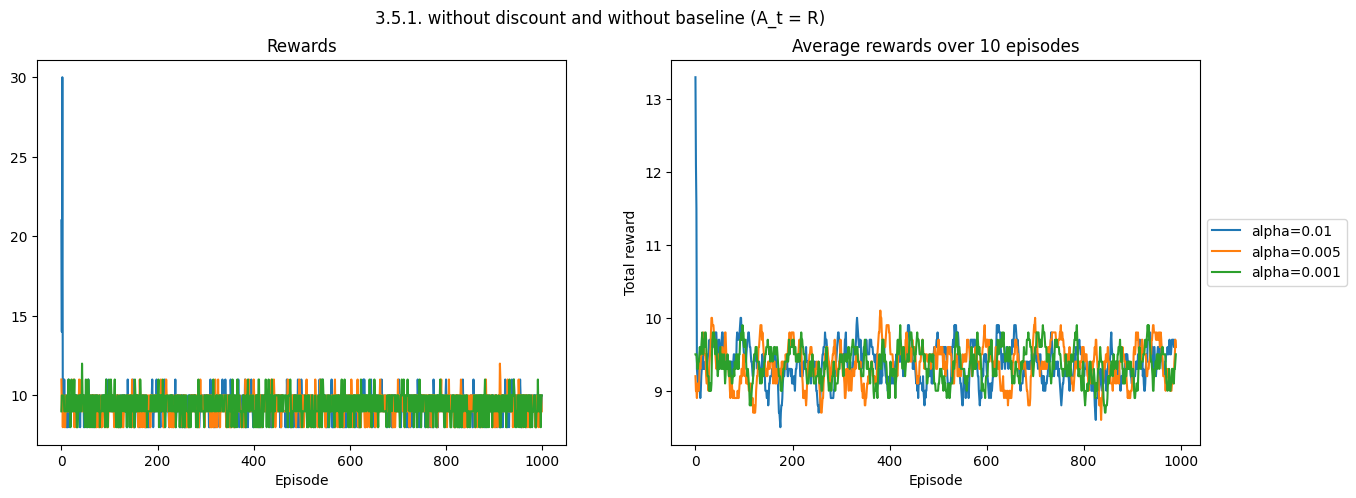

--------------------------------------------------------------------------------
[End] 3.5.1. without discount and without baseline (A_t = R)
[Start] 3.5.1. with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 9.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 8.0
[alpha=0.01] Episode 300: 22.0
[alpha=0.01] Episode 350: 9.0
[alpha=0.01] Episode 400: 10.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 10.0
[alpha=0.01] Episode 550: 9.0
[alpha=0.01] Episode 600: 10.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 10.0
[alpha=0.01] Episode 750: 10.0
[alpha=0.01] Episode 800: 8.0
[alpha=0.01] Episode 850: 9.0
[alpha=0.01] Episode 900: 10.0
[alpha=0.01] Episode 950: 10.0
[alpha=0.01] Episode 1000: 9.0
[alpha=0.005] Episode 50: 10.0
[alpha=0.005] Episode 100: 8.0
[alpha=0.005] Episode 150: 10.0
[alpha=0.005] Episode

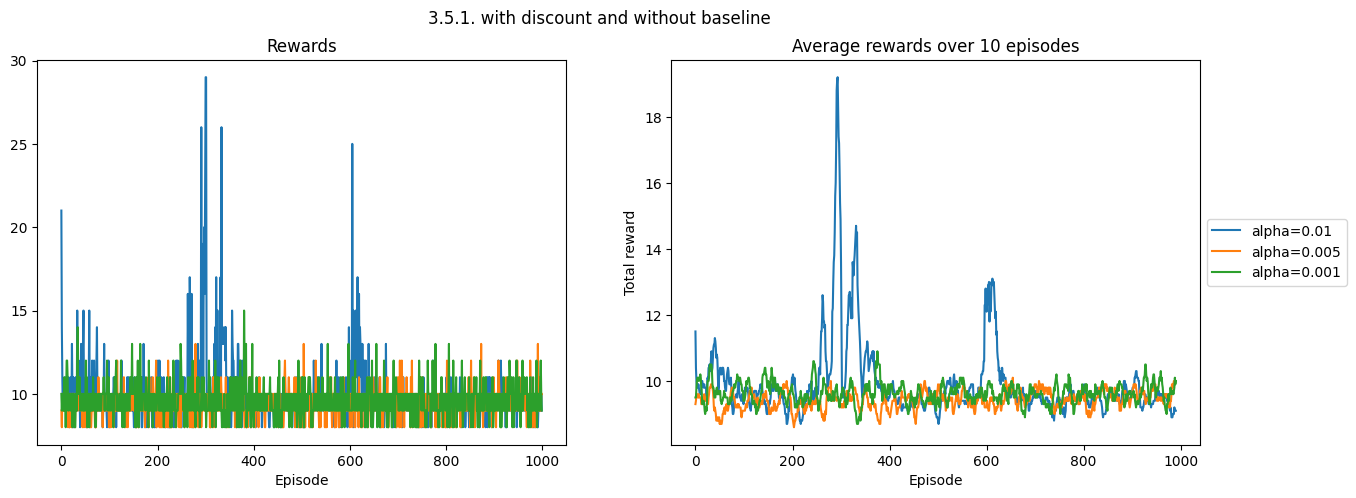

--------------------------------------------------------------------------------
[End] 3.5.1. with discount and without baseline
[Start] 3.5.1. without discount and with baseline
--------------------------------------------------------------------------------


C:\Users\Asus\AppData\Local\Temp\ipykernel_18760\2603588583.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  v_net(torch.tensor(history.states, dtype=torch.float32)).squeeze(-1)


[alpha=0.01] Episode 50: 14.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 15.0
[alpha=0.01] Episode 200: 13.0
[alpha=0.01] Episode 250: 10.0
[alpha=0.01] Episode 300: 13.0
[alpha=0.01] Episode 350: 11.0
[alpha=0.01] Episode 400: 14.0
[alpha=0.01] Episode 450: 21.0
[alpha=0.01] Episode 500: 45.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 29.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 19.0
[alpha=0.01] Episode 750: 25.0
[alpha=0.01] Episode 800: 34.0
[alpha=0.01] Episode 850: 13.0
[alpha=0.01] Episode 900: 33.0
[alpha=0.01] Episode 950: 24.0
[alpha=0.01] Episode 1000: 21.0
[alpha=0.005] Episode 50: 51.0
[alpha=0.005] Episode 100: 47.0
[alpha=0.005] Episode 150: 20.0
[alpha=0.005] Episode 200: 31.0
[alpha=0.005] Episode 250: 11.0
[alpha=0.005] Episode 300: 15.0
[alpha=0.005] Episode 350: 25.0
[alpha=0.005] Episode 400: 25.0
[alpha=0.005] Episode 450: 12.0
[alpha=0.005] Episode 500: 14.0
[alpha=0.005] Episode 550: 22.0
[alpha=0.005] Episode 600: 36

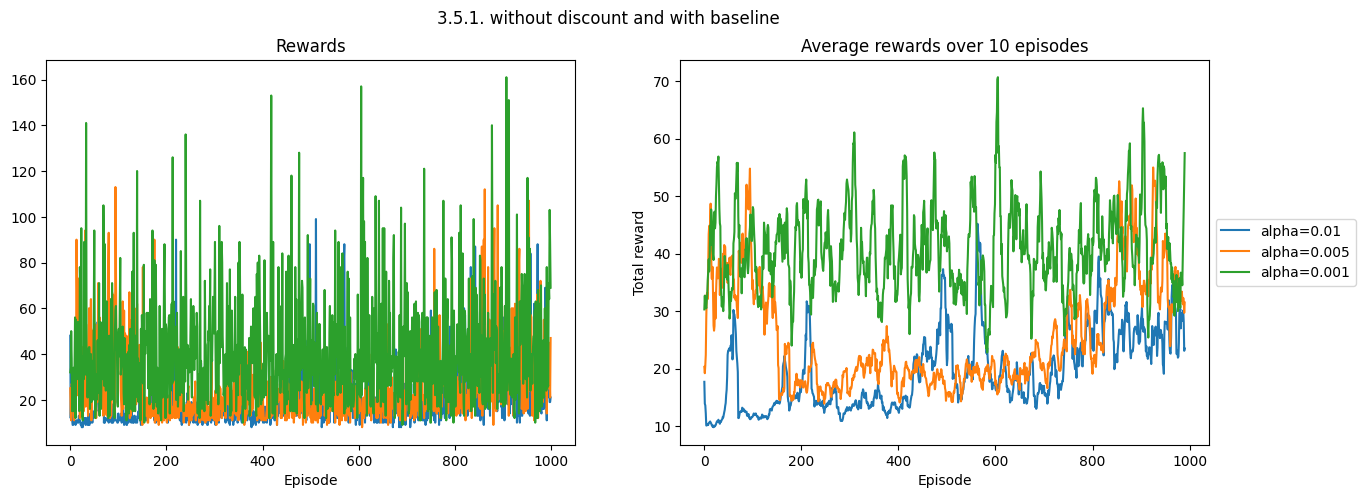

--------------------------------------------------------------------------------
[End] 3.5.1. without discount and with baseline
[Start] 3.5.1. with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 86.0
[alpha=0.01] Episode 250: 37.0
[alpha=0.01] Episode 300: 25.0
[alpha=0.01] Episode 350: 39.0
[alpha=0.01] Episode 400: 41.0
[alpha=0.01] Episode 450: 17.0
[alpha=0.01] Episode 500: 20.0
[alpha=0.01] Episode 550: 58.0
[alpha=0.01] Episode 600: 77.0
[alpha=0.01] Episode 650: 131.0
[alpha=0.01] Episode 700: 48.0
[alpha=0.01] Episode 750: 100.0
[alpha=0.01] Episode 800: 94.0
[alpha=0.01] Episode 850: 121.0
[alpha=0.01] Episode 900: 36.0
[alpha=0.01] Episode 950: 99.0
[alpha=0.01] Episode 1000: 17.0
[alpha=0.005] Episode 50: 20.0
[alpha=0.005] Episode 100: 25.0
[alpha=0.005] Episode 150: 17.0
[alpha=0.005] Episode 200

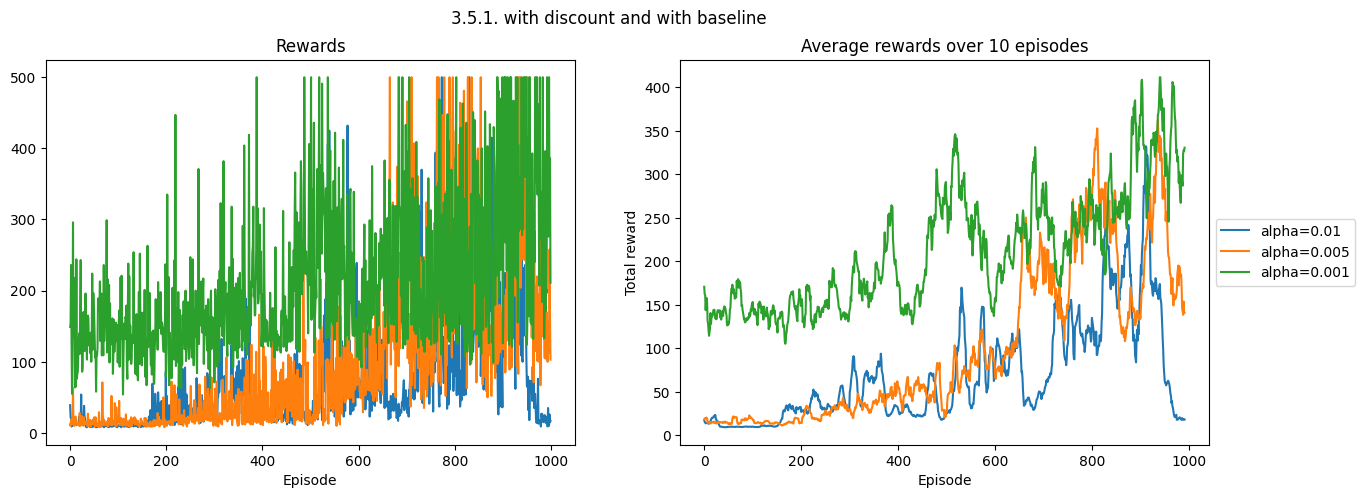

--------------------------------------------------------------------------------
[End] 3.5.1. with discount and with baseline
[Start] 3.5.3.1. [optimizer: SGD with Momentum] without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 9.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 10.0
[alpha=0.01] Episode 300: 8.0
[alpha=0.01] Episode 350: 10.0
[alpha=0.01] Episode 400: 10.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 9.0
[alpha=0.01] Episode 550: 9.0
[alpha=0.01] Episode 600: 9.0
[alpha=0.01] Episode 650: 9.0
[alpha=0.01] Episode 700: 9.0
[alpha=0.01] Episode 750: 10.0
[alpha=0.01] Episode 800: 10.0
[alpha=0.01] Episode 850: 9.0
[alpha=0.01] Episode 900: 8.0
[alpha=0.01] Episode 950: 9.0
[alpha=0.01] Episode 1000: 8.0
[alpha=0.005] Episode 50: 10.0
[alpha=0.005] Episode 100: 9.0
[alpha=0.005] Episode 150: 

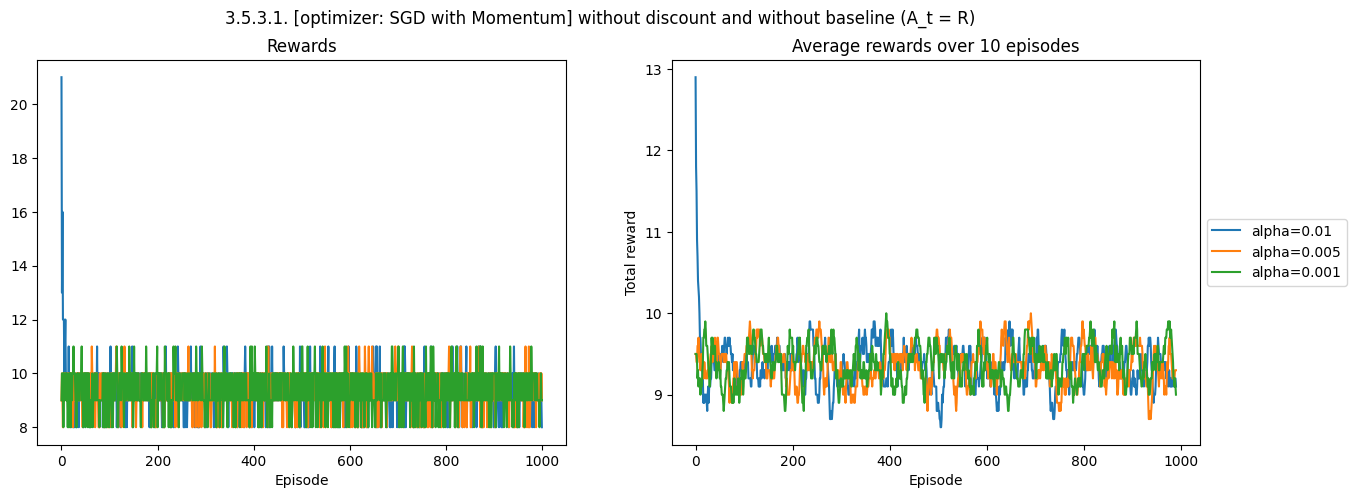

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] without discount and without baseline (A_t = R)
[Start] 3.5.3.1. [optimizer: SGD with Momentum] with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 15.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 10.0
[alpha=0.01] Episode 200: 10.0
[alpha=0.01] Episode 250: 8.0
[alpha=0.01] Episode 300: 13.0
[alpha=0.01] Episode 350: 15.0
[alpha=0.01] Episode 400: 15.0
[alpha=0.01] Episode 450: 9.0
[alpha=0.01] Episode 500: 19.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 19.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 11.0
[alpha=0.01] Episode 750: 11.0
[alpha=0.01] Episode 800: 12.0
[alpha=0.01] Episode 850: 11.0
[alpha=0.01] Episode 900: 9.0
[alpha=0.01] Episode 950: 9.0
[alpha=0.01] Episode 1000: 10.0
[alpha=0.005] Episode 50: 12.0
[alpha=0.005] 

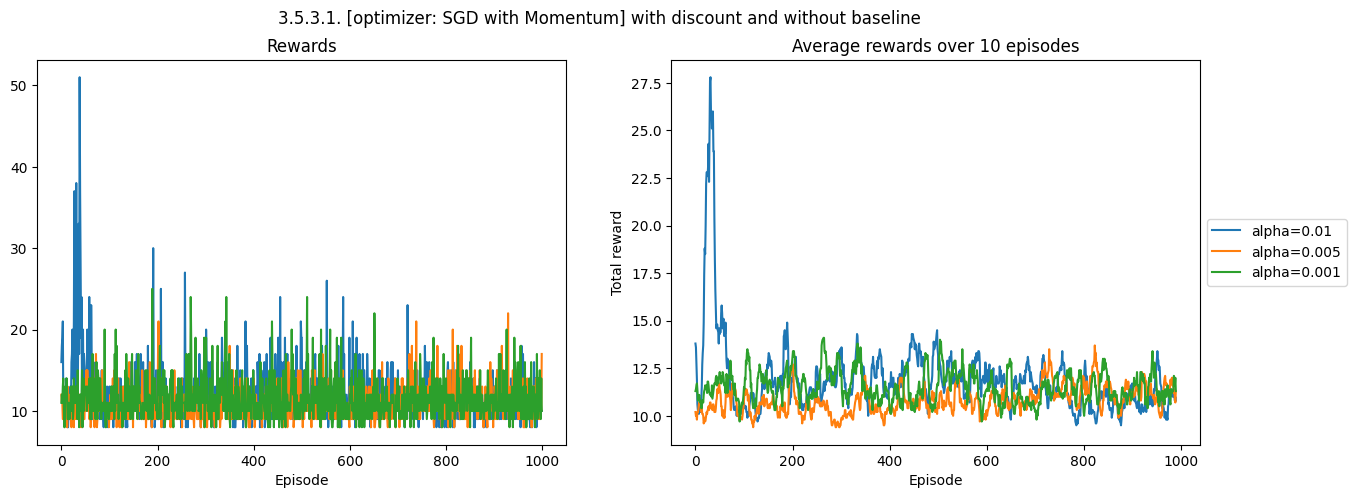

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] with discount and without baseline
[Start] 3.5.3.1. [optimizer: SGD with Momentum] without discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 17.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 11.0
[alpha=0.01] Episode 300: 10.0
[alpha=0.01] Episode 350: 9.0
[alpha=0.01] Episode 400: 10.0
[alpha=0.01] Episode 450: 9.0
[alpha=0.01] Episode 500: 9.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 12.0
[alpha=0.01] Episode 650: 9.0
[alpha=0.01] Episode 700: 9.0
[alpha=0.01] Episode 750: 13.0
[alpha=0.01] Episode 800: 19.0
[alpha=0.01] Episode 850: 10.0
[alpha=0.01] Episode 900: 13.0
[alpha=0.01] Episode 950: 15.0
[alpha=0.01] Episode 1000: 22.0
[alpha=0.005] Episode 50: 25.0
[alpha=0.005] Episode 100: 26

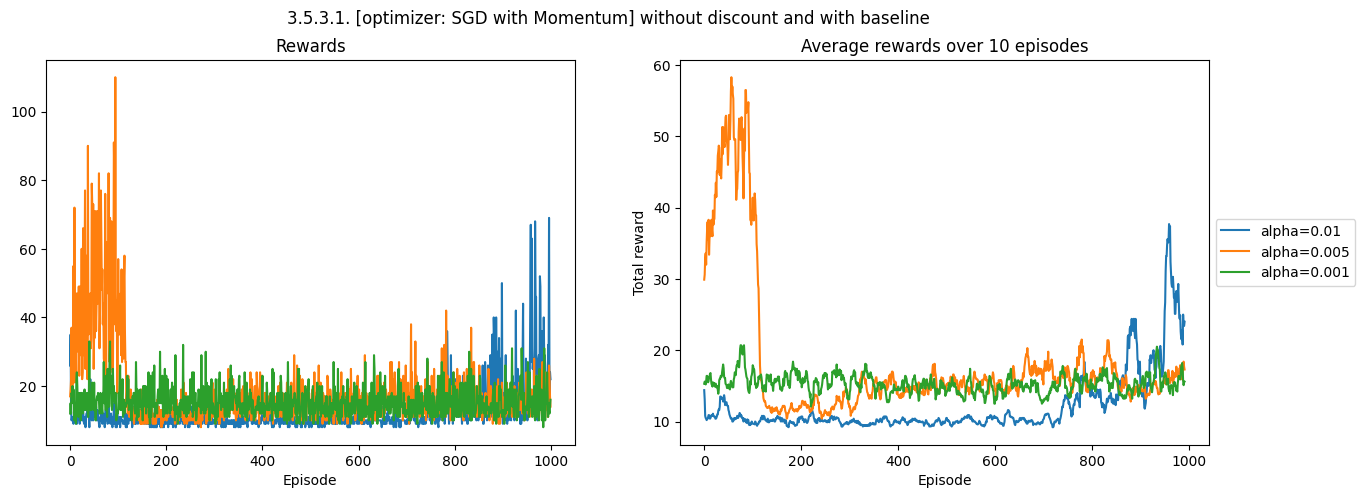

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] without discount and with baseline
[Start] 3.5.3.1. [optimizer: SGD with Momentum] with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 11.0
[alpha=0.01] Episode 100: 8.0
[alpha=0.01] Episode 150: 13.0
[alpha=0.01] Episode 200: 11.0
[alpha=0.01] Episode 250: 20.0
[alpha=0.01] Episode 300: 12.0
[alpha=0.01] Episode 350: 10.0
[alpha=0.01] Episode 400: 15.0
[alpha=0.01] Episode 450: 14.0
[alpha=0.01] Episode 500: 11.0
[alpha=0.01] Episode 550: 16.0
[alpha=0.01] Episode 600: 17.0
[alpha=0.01] Episode 650: 11.0
[alpha=0.01] Episode 700: 18.0
[alpha=0.01] Episode 750: 11.0
[alpha=0.01] Episode 800: 11.0
[alpha=0.01] Episode 850: 17.0
[alpha=0.01] Episode 900: 21.0
[alpha=0.01] Episode 950: 17.0
[alpha=0.01] Episode 1000: 14.0
[alpha=0.005] Episode 50: 58.0
[alpha=0.005] Episode 100: 

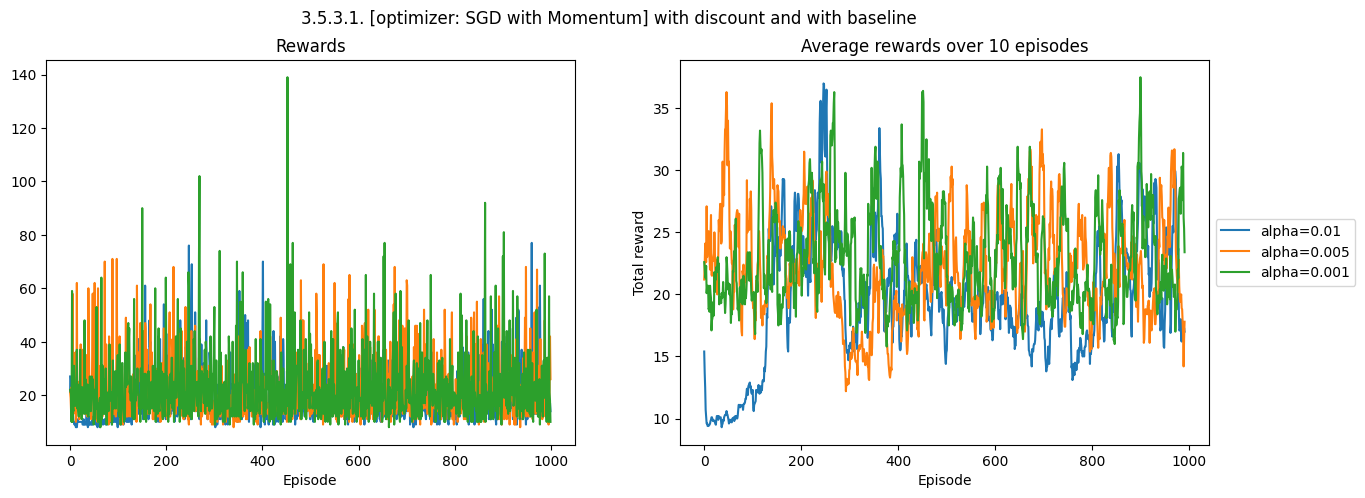

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] with discount and with baseline
[Start] 3.5.3.1. [optimizer: RMSProp] without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 9.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 12.0
[alpha=0.01] Episode 250: 14.0
[alpha=0.01] Episode 300: 33.0
[alpha=0.01] Episode 350: 76.0
[alpha=0.01] Episode 400: 50.0
[alpha=0.01] Episode 450: 52.0
[alpha=0.01] Episode 500: 65.0
[alpha=0.01] Episode 550: 170.0
[alpha=0.01] Episode 600: 161.0
[alpha=0.01] Episode 650: 99.0
[alpha=0.01] Episode 700: 98.0
[alpha=0.01] Episode 750: 118.0
[alpha=0.01] Episode 800: 349.0
[alpha=0.01] Episode 850: 50.0
[alpha=0.01] Episode 900: 343.0
[alpha=0.01] Episode 950: 500.0
[alpha=0.01] Episode 1000: 189.0
[alpha=0.005] Episode 50: 273.0
[alpha=0.005] Ep

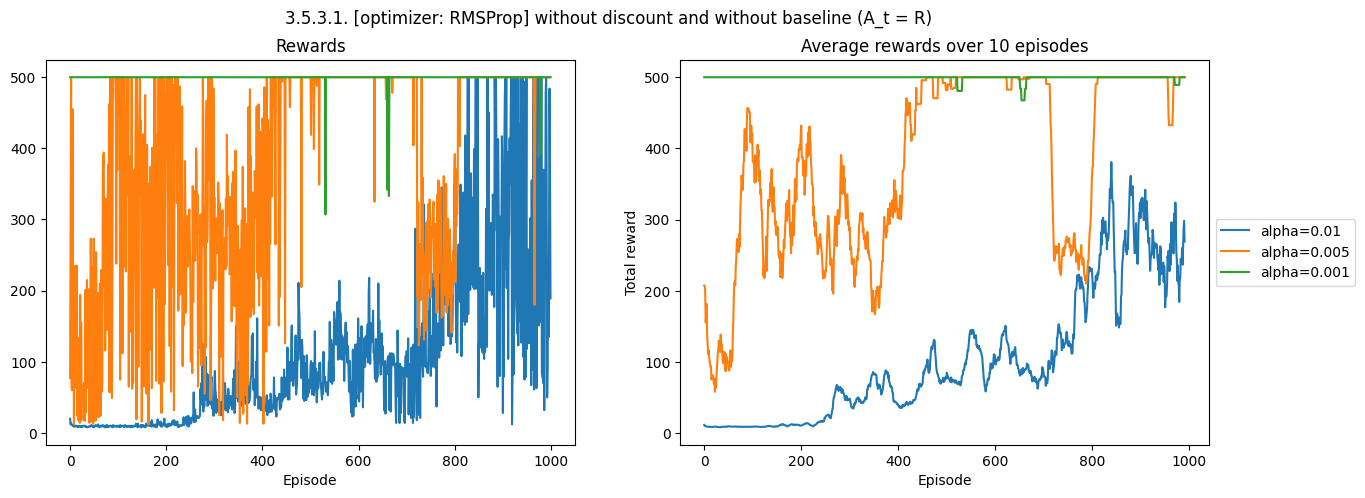

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] without discount and without baseline (A_t = R)
[Start] 3.5.3.1. [optimizer: RMSProp] with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 10.0
[alpha=0.01] Episode 200: 8.0
[alpha=0.01] Episode 250: 9.0
[alpha=0.01] Episode 300: 8.0
[alpha=0.01] Episode 350: 8.0
[alpha=0.01] Episode 400: 8.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 9.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 10.0
[alpha=0.01] Episode 650: 8.0
[alpha=0.01] Episode 700: 10.0
[alpha=0.01] Episode 750: 9.0
[alpha=0.01] Episode 800: 8.0
[alpha=0.01] Episode 850: 11.0
[alpha=0.01] Episode 900: 10.0
[alpha=0.01] Episode 950: 10.0
[alpha=0.01] Episode 1000: 10.0
[alpha=0.005] Episode 50: 10.0
[alpha=0.005] Episode 100: 10.0
[alpha=

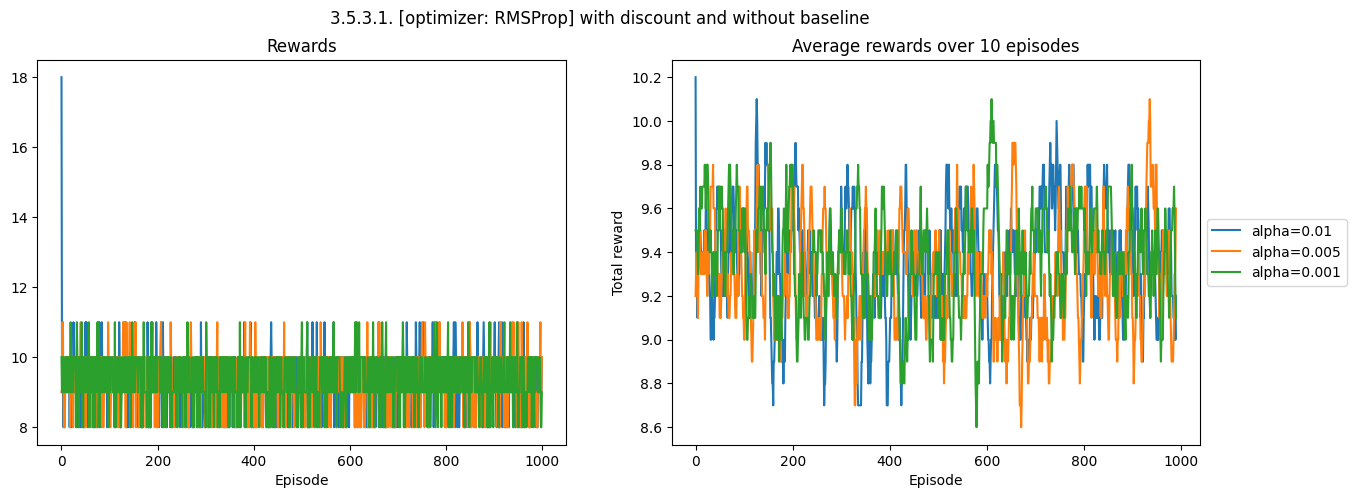

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] with discount and without baseline
[Start] 3.5.3.1. [optimizer: RMSProp] without discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 33.0
[alpha=0.01] Episode 100: 150.0
[alpha=0.01] Episode 150: 45.0
[alpha=0.01] Episode 200: 129.0
[alpha=0.01] Episode 250: 153.0
[alpha=0.01] Episode 300: 117.0
[alpha=0.01] Episode 350: 186.0
[alpha=0.01] Episode 400: 136.0
[alpha=0.01] Episode 450: 157.0
[alpha=0.01] Episode 500: 161.0
[alpha=0.01] Episode 550: 350.0
[alpha=0.01] Episode 600: 227.0
[alpha=0.01] Episode 650: 500.0
[alpha=0.01] Episode 700: 380.0
[alpha=0.01] Episode 750: 500.0
[alpha=0.01] Episode 800: 500.0
[alpha=0.01] Episode 850: 500.0
[alpha=0.01] Episode 900: 260.0
[alpha=0.01] Episode 950: 145.0
[alpha=0.01] Episode 1000: 113.0
[alpha=0.005] Episode 50: 165.0
[alpha=0.005] Episode 10

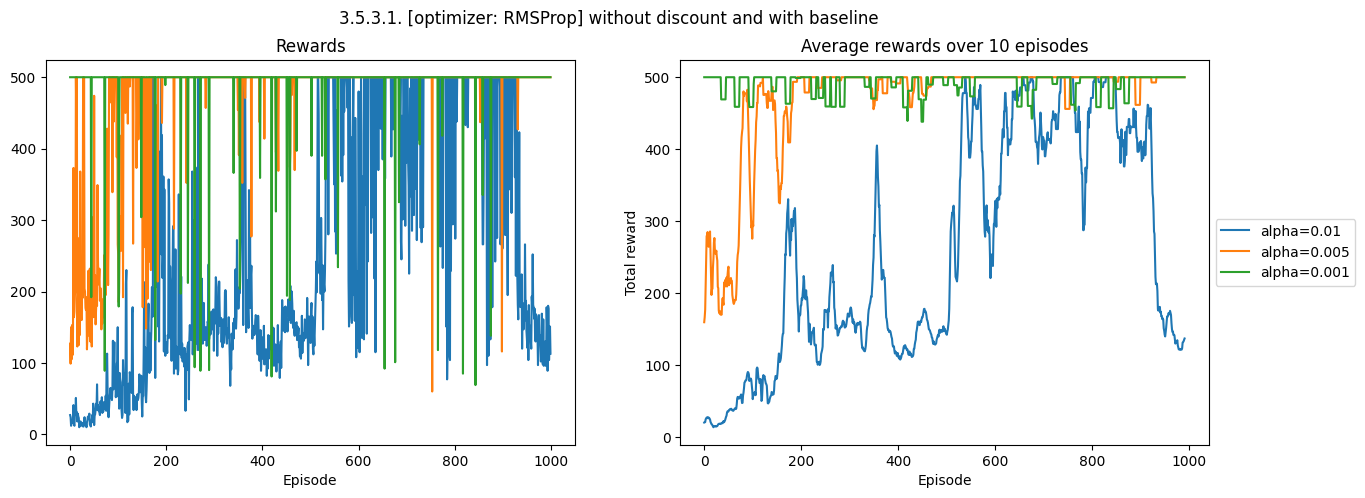

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] without discount and with baseline
[Start] 3.5.3.1. [optimizer: RMSProp] with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 106.0
[alpha=0.01] Episode 100: 500.0
[alpha=0.01] Episode 150: 472.0
[alpha=0.01] Episode 200: 122.0
[alpha=0.01] Episode 250: 112.0
[alpha=0.01] Episode 300: 500.0
[alpha=0.01] Episode 350: 297.0
[alpha=0.01] Episode 400: 203.0
[alpha=0.01] Episode 450: 172.0
[alpha=0.01] Episode 500: 58.0
[alpha=0.01] Episode 550: 220.0
[alpha=0.01] Episode 600: 500.0
[alpha=0.01] Episode 650: 463.0
[alpha=0.01] Episode 700: 212.0
[alpha=0.01] Episode 750: 149.0
[alpha=0.01] Episode 800: 197.0
[alpha=0.01] Episode 850: 358.0
[alpha=0.01] Episode 900: 173.0
[alpha=0.01] Episode 950: 109.0
[alpha=0.01] Episode 1000: 186.0
[alpha=0.005] Episode 50: 500.0
[alpha=0.005] Episode 100:

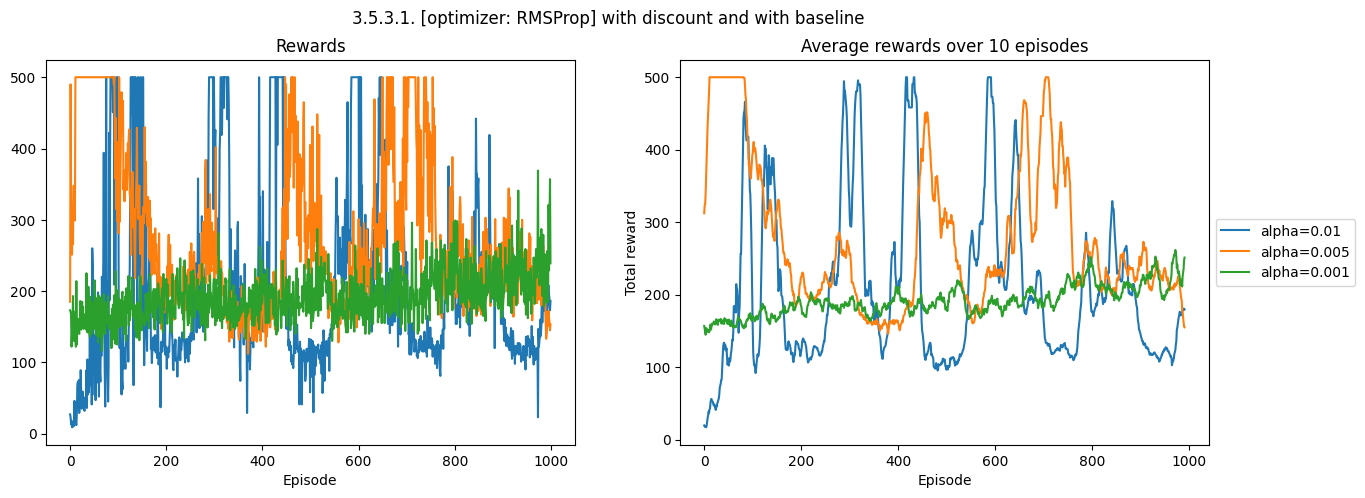

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] with discount and with baseline
[Start] 3.5.3.1. [optimizer: Adam] without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 25.0
[alpha=0.01] Episode 100: 69.0
[alpha=0.01] Episode 150: 113.0
[alpha=0.01] Episode 200: 460.0
[alpha=0.01] Episode 250: 15.0
[alpha=0.01] Episode 300: 17.0
[alpha=0.01] Episode 350: 35.0
[alpha=0.01] Episode 400: 69.0
[alpha=0.01] Episode 450: 137.0
[alpha=0.01] Episode 500: 447.0
[alpha=0.01] Episode 550: 113.0
[alpha=0.01] Episode 600: 134.0
[alpha=0.01] Episode 650: 153.0
[alpha=0.01] Episode 700: 181.0
[alpha=0.01] Episode 750: 202.0
[alpha=0.01] Episode 800: 500.0
[alpha=0.01] Episode 850: 232.0
[alpha=0.01] Episode 900: 500.0
[alpha=0.01] Episode 950: 115.0
[alpha=0.01] Episode 1000: 119.0
[alpha=0.005] Episode 50: 124.0
[alpha=0.005] Episode

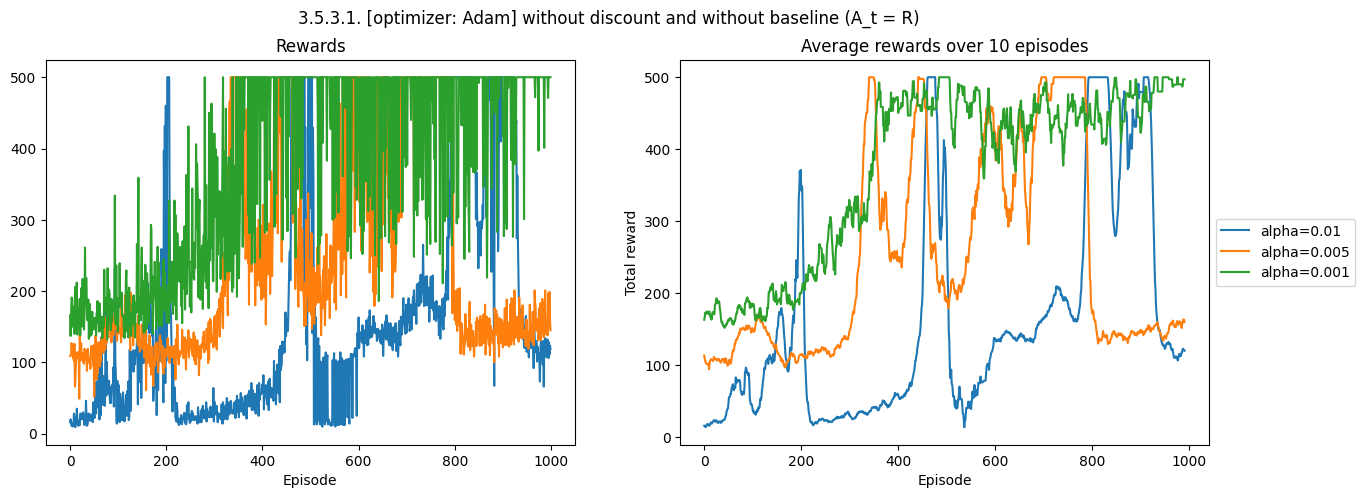

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] without discount and without baseline (A_t = R)
[Start] 3.5.3.1. [optimizer: Adam] with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 29.0
[alpha=0.01] Episode 100: 35.0
[alpha=0.01] Episode 150: 24.0
[alpha=0.01] Episode 200: 78.0
[alpha=0.01] Episode 250: 51.0
[alpha=0.01] Episode 300: 45.0
[alpha=0.01] Episode 350: 20.0
[alpha=0.01] Episode 400: 113.0
[alpha=0.01] Episode 450: 165.0
[alpha=0.01] Episode 500: 41.0
[alpha=0.01] Episode 550: 82.0
[alpha=0.01] Episode 600: 21.0
[alpha=0.01] Episode 650: 137.0
[alpha=0.01] Episode 700: 42.0
[alpha=0.01] Episode 750: 71.0
[alpha=0.01] Episode 800: 59.0
[alpha=0.01] Episode 850: 50.0
[alpha=0.01] Episode 900: 160.0
[alpha=0.01] Episode 950: 95.0
[alpha=0.01] Episode 1000: 36.0
[alpha=0.005] Episode 50: 75.0
[alpha=0.005] Episode 100: 129.0

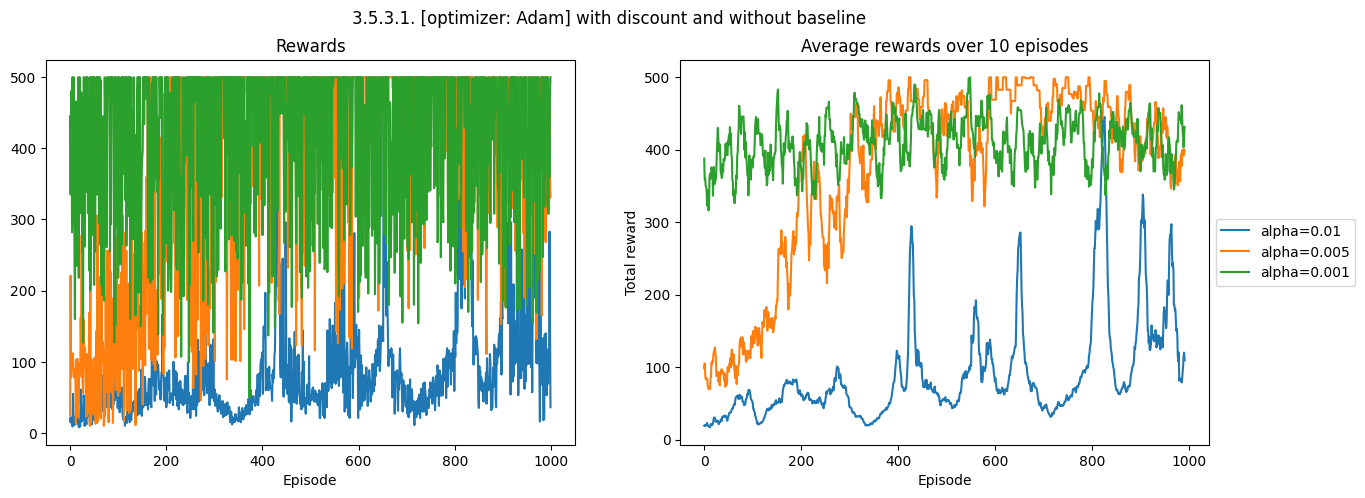

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] with discount and without baseline
[Start] 3.5.3.1. [optimizer: Adam] without discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 91.0
[alpha=0.01] Episode 100: 93.0
[alpha=0.01] Episode 150: 417.0
[alpha=0.01] Episode 200: 124.0
[alpha=0.01] Episode 250: 223.0
[alpha=0.01] Episode 300: 13.0
[alpha=0.01] Episode 350: 483.0
[alpha=0.01] Episode 400: 500.0
[alpha=0.01] Episode 450: 74.0
[alpha=0.01] Episode 500: 376.0
[alpha=0.01] Episode 550: 237.0
[alpha=0.01] Episode 600: 169.0
[alpha=0.01] Episode 650: 18.0
[alpha=0.01] Episode 700: 367.0
[alpha=0.01] Episode 750: 500.0
[alpha=0.01] Episode 800: 150.0
[alpha=0.01] Episode 850: 500.0
[alpha=0.01] Episode 900: 500.0
[alpha=0.01] Episode 950: 139.0
[alpha=0.01] Episode 1000: 170.0
[alpha=0.005] Episode 50: 453.0
[alpha=0.005] Episode 100: 397.0


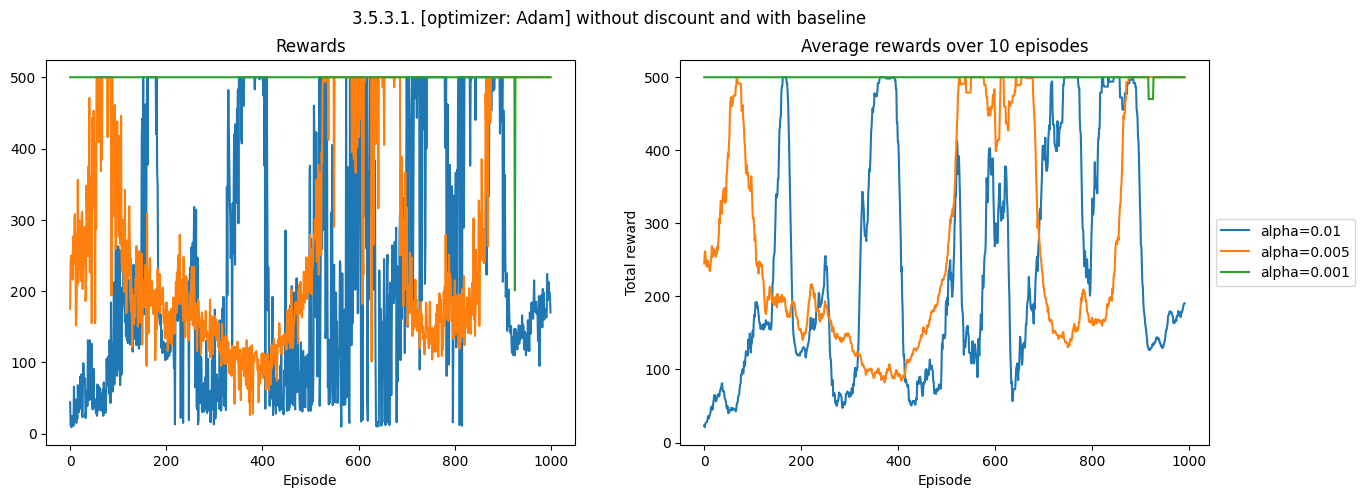

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] without discount and with baseline
[Start] 3.5.3.1. [optimizer: Adam] with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 11.0
[alpha=0.01] Episode 100: 52.0
[alpha=0.01] Episode 150: 63.0
[alpha=0.01] Episode 200: 183.0
[alpha=0.01] Episode 250: 413.0
[alpha=0.01] Episode 300: 432.0
[alpha=0.01] Episode 350: 302.0
[alpha=0.01] Episode 400: 140.0
[alpha=0.01] Episode 450: 500.0
[alpha=0.01] Episode 500: 341.0
[alpha=0.01] Episode 550: 500.0
[alpha=0.01] Episode 600: 224.0
[alpha=0.01] Episode 650: 397.0
[alpha=0.01] Episode 700: 500.0
[alpha=0.01] Episode 750: 284.0
[alpha=0.01] Episode 800: 500.0
[alpha=0.01] Episode 850: 500.0
[alpha=0.01] Episode 900: 500.0
[alpha=0.01] Episode 950: 500.0
[alpha=0.01] Episode 1000: 500.0
[alpha=0.005] Episode 50: 500.0
[alpha=0.005] Episode 100: 500.0
[

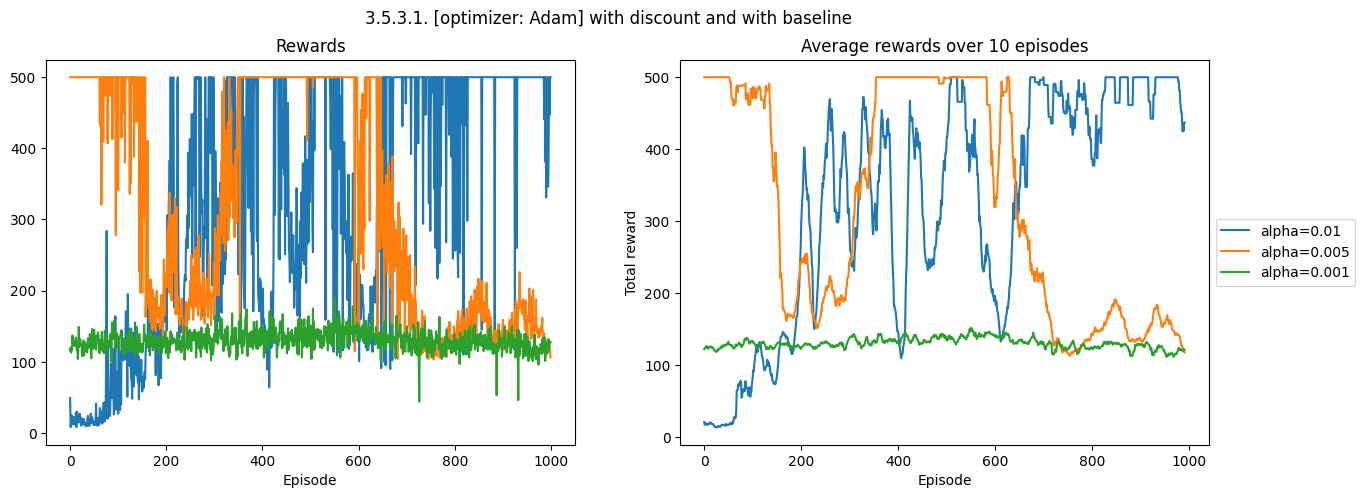

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] with discount and with baseline


In [8]:
debug = False

def run(
    title: str,
    env_name: str,
    n_episodes = 1000,
    use_v_net: bool = False,
    discount = 1.0,
    seed = 42,
    get_optimizer = get_default_optimizer,
):
    print('=' * 80)
    print(f'[Start] {title}')
    print('-' * 80)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env = gym.make(env_name)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    policy = GradientPolicy(n_states, n_actions)
    v_net = StateValueNetwork(n_states) if use_v_net else None
    manager = Manager(
        env=env,
        policy=policy,
        v_net=v_net,
        discount=discount,
        debug=debug,
        get_policy_optimizer=get_optimizer,
        get_v_optimizer=get_optimizer)
    manager.train(title=title, n_episodes=n_episodes)
    print('-' * 80)
    print(f'[End] {title}')
    print('=' * 80)

def run_cases(number: int, env_name: str, n_episodes = 1000):
    optimizers_fn = [
        (None, get_default_optimizer),
        ('SGD with Momentum', lambda model, lr: torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)),
        ('RMSProp', lambda model, lr: torch.optim.RMSprop(model.parameters(), lr=lr)),
        ('Adam', lambda model, lr: torch.optim.Adam(model.parameters(), lr=lr)),
    ]

    for optimizer_name, get_optimizer in optimizers_fn:
        optimizer_info = '' if optimizer_name is None else f' [optimizer: {optimizer_name}]'
        number_suffix = number if optimizer_name is None else f'3.{number}'
        run(
            f'3.5.{number_suffix}.{optimizer_info} without discount and without baseline (A_t = R)',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=False,
            discount=1.0,
            get_optimizer=get_optimizer)
        run(
            f'3.5.{number_suffix}.{optimizer_info} with discount and without baseline',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=False,
            discount=0.9,
            get_optimizer=get_optimizer)
        run(
            f'3.5.{number_suffix}.{optimizer_info} without discount and with baseline',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=True,
            discount=1.0,
            get_optimizer=get_optimizer)
        run(
            f'3.5.{number_suffix}.{optimizer_info} with discount and with baseline',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=True,
            discount=0.9,
            get_optimizer=get_optimizer)

run_cases(number=1, env_name='CartPole-v1', n_episodes = 1000)

The best cases were:

- RMSProp: alpha 0.001, without discount (with and without baseline)

- Adam: alpha 0.001, without discount and with baseline

Those 3 cases reached the maximum reward of 500 in less than 50 episodes (the number of steps to truncate the episode, taking into account that the agent receives 1 reward per time step).

### 3.5.2 Apply it to the Swimmer environment.

In [ ]:
if not is_windows():
    run_cases(number=2, env_name='Swimmer-v3', n_episodes = 1000)

### 5.1 Exercises

5.1.1. Implement Watkins' Q-learning and apply it to toy_text gym environments. You may also want to compute the optimal solution using policy iteration and compare the performance. (Note that these environments provide the transition and reward functions for your convenience.)

5.1.2. Apply a batch Q-value iteration algorithm or DQN to the classic_control environments.

5.1.3. Apply a batch Q-value iteration algorithm or DQN to the mujoco environments, using a quadratic Q-function.

In [1]:
import time
from matplotlib import pyplot as plt
from gymnasium import Env
from IPython.display import display, update_display

class EnvRenderer:
    def __init__(self):
        self.display_id: str | None = None

    def render(self, env: Env):
        display_id = self.display_id

        plt.figure()

        # Render and display the new image
        plt.imshow(env.render())

        if not display_id:
            dh = display(plt.gcf(), display_id=True)
            self.display_id = dh.display_id
        else:
            # Clear the previous rendered image
            update_display(plt.gcf(), display_id=display_id)

        plt.close()

        # Sleep for a short time to simulate the loop delay
        time.sleep(3 if not display_id else 0.1)

    def reset(self):
        self.display_id = None

In [2]:
import numpy as np
from gymnasium import Env

class PolicyIteratorDPQ:
    def __init__(self, env: Env, gamma=0.9, theta=1e-5):
        self.P = env.unwrapped.P if hasattr(env.unwrapped, 'P') else None
        self.n_states = env.observation_space.n if hasattr(env.observation_space, 'n') else None
        self.n_actions = env.action_space.n if hasattr(env.action_space, 'n') else None
        self.gamma = gamma
        self.theta = theta

    def get_defined_props(self):
        P = self.P
        n_states = self.n_states
        n_actions = self.n_actions

        if P is None or n_states is None or n_actions is None:
            return False, None

        return True, (P, n_states, n_actions)

    def has_model(self):
        ok, _ = self.get_defined_props()
        return ok

    def run(self, debug=False):
        _, (P, n_states, n_actions) = self.get_defined_props()
        gamma = self.gamma
        theta = self.theta
        Q = np.zeros((n_states, n_actions))
        counter = 0

        while True:
            delta = 0
            for s in range(n_states):
                for a in range(n_actions):
                    q = Q[s, a]
                    Q[s, a] = sum(
                        p * (r + gamma * (np.max(Q[s_] if not d else 0)))
                        for p, s_, r, d in P[s][a])
                    delta = max(delta, np.abs(Q[s, a] - q))

            counter += 1
            if debug:
                if counter % 1000 == 0:
                    print(f'[DP] Counter: {counter}, Delta: {delta}')

            if delta < theta:
                break

        return Q, counter

In [50]:
import numpy as np
import gymnasium as gym
from gymnasium import Env
import matplotlib.pyplot as plt
import typing
from functools import reduce

class WatkinsQAgent:
    def __init__(
        self,
        env: Env,
        test_env: Env | None = None,
        epsilon=0.1,
        alpha=0.1,
        gamma=0.9,
        decrease=True,
        won: typing.Callable[[bool, float], bool] | None = None,
        initial_q_val=0.0,
        greedy_with_noise=False,
        observation_shape: tuple[int, ...] | None = None,
        seed: int | None = None,
    ):
        env_name = env.spec.id
        observation_shape = (
            env.observation_space.shape
            if env.observation_space.shape is not None
            else observation_shape)
        action_shape = env.action_space.shape
        n_states = (
            reduce(lambda x, y: x * y, observation_shape)
            if len(observation_shape) > 0
            else env.observation_space.n)
        n_actions = (
            reduce(lambda x, y: x * y, action_shape)
            if len(action_shape) > 0
            else env.action_space.n)

        test_env = (
            test_env
            if test_env is not None
            else gym.make(env_name, render_mode='rgb_array'))

        self.env_name = env_name
        self.env = env
        self.test_env = test_env
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.initial_epsilon = epsilon
        self.initial_alpha = alpha
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.decrease = decrease
        self.n_states = n_states
        self.n_actions = n_actions
        self.q_table = np.full((n_states, n_actions), initial_q_val)
        self.q_dp: np.array | None = None
        self.won = won
        self.greedy_with_noise = greedy_with_noise
        self.seed = seed

    def content_to_idx(self, content: int | tuple[int, ...], shape: tuple[int, ...]) -> int:
        if len(shape) > 0:
            idx = reduce(lambda acc, i: acc * shape[i] + content[i], range(len(shape)), 0)
            return idx
        else:
            return content

    def idx_to_content(self, idx: int, shape: tuple[int, ...]) -> int | tuple[int, ...]:
        if len(shape) > 0:
            content = []
            for i in range(len(shape)-1, -1, -1):
                content.append(idx % shape[i])
                idx //= shape[i]
            return tuple(reversed(content))
        else:
            return idx

    def state_to_idx(self, state: int | tuple[int, ...]) -> int:
        return self.content_to_idx(state, self.observation_shape)

    def idx_to_state(self, state_idx: int) -> int | tuple[int, ...]:
        return self.idx_to_content(state_idx, self.observation_shape)

    def action_to_idx(self, action: int | tuple[int, ...]) -> int:
        return self.content_to_idx(action, self.action_shape)

    def idx_to_action(self, action_idx: int) -> int | tuple[int, ...]:
        return self.idx_to_content(action_idx, self.action_shape)

    def act(self, state_idx: int, episode=1) -> int | tuple[int, ...]:
        action_idx = (
            np.argmax(
                self.q_table[state_idx,:]
                +
                np.random.randn(1, self.n_actions)*(5./episode)
            )
            if self.greedy_with_noise
            else (
                np.random.choice(self.n_actions)
                if np.random.rand() < self.epsilon
                else np.argmax(self.q_table[state_idx])
            )
        )
        return self.idx_to_action(action_idx)

    def train(self, n_episodes=1000, plot=False, debug=False):
        env = self.env
        gamma = self.gamma
        q_table = self.q_table
        seed = self.seed
        won = self.won
        steps: list[int] = []
        rewards: list[float] = []
        errors: list[float] = []
        mean_counter = 0
        mean_reward = 0.0
        window_amount = 20
        window = max(n_episodes // window_amount, 1)
        dpq = PolicyIteratorDPQ(env, gamma=gamma)
        q_dp: np.array | None = None

        if seed:
            np.random.seed(seed)

        def episode_seed():
            return None if not seed else np.random.randint(max(n_episodes, 1000) - 1)

        if dpq.has_model():
            q_dp, dp_iter = dpq.run(debug=debug)
            self.q_dp = q_dp
            print(f'[{self.env_name}] DPQ converged in {dp_iter} iterations')

        for i in range(n_episodes):
            state, _ = env.reset(seed=episode_seed())
            state_idx = self.state_to_idx(state)
            terminated = False
            done = False
            episode_steps = 0
            episode_reward = 0
            wins = 0

            while not done:
                action = self.act(state_idx=state_idx, episode=i+1)
                action_idx = self.action_to_idx(action)

                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state_idx = self.state_to_idx(next_state)
                done = terminated or truncated

                episode_steps += 1
                episode_reward += reward

                target = reward + gamma * (np.max(q_table[next_state_idx]) if not terminated else 0)
                q_table[state_idx, action_idx] += self.alpha * (target - q_table[state_idx, action_idx])
                state_idx = next_state_idx

            if self.decrease and terminated and (not won or won(terminated, episode_reward)):
                wins += 1
                self.alpha = (1.0/(wins+1)) * self.initial_alpha
                self.epsilon = (1.0/(wins+1)) * self.initial_epsilon

            steps.append(episode_steps)
            rewards.append(episode_reward)
            mean_counter += 1
            mean_reward += (episode_reward - mean_reward) / mean_counter

            if debug and (i+1) % window == 0:
                error: int | None = None
                if q_dp is not None:
                    error = sum([
                        np.abs(q_table[s, a] - q_dp[s, a])
                        for s in range(self.n_states)
                        for a in range(self.n_actions)
                    ])
                    errors.append(error)

                episode_str = f'Episode {i+1}'
                steps_str = f'steps={episode_steps}'
                reward_str = f', reward={episode_reward}'
                mean_str = f', mean={mean_reward:.2f}'
                error_str = f', error={error:.2f}' if error is not None else ''
                mean_q_str = f', mean Q={np.mean(q_table):.2f}'
                dev_q_str = f', dev Q={np.std(q_table):.2f}'
                max_q_str = f', max Q={np.max(q_table):.2f}'
                min_q_str = f', min Q={np.min(q_table):.2f}'
                q_str = f'{mean_q_str}{dev_q_str}{max_q_str}{min_q_str}'
                print(f'[{self.env_name}] {episode_str}: {steps_str}{reward_str}{mean_str}{error_str}{q_str}')
                mean_counter = 0
                mean_reward = 0.0

        if plot:
            n_rows = 1 if not errors else 2
            n_cols = 3 if not errors else 2
            idx = 0

            idx += 1
            plt.figure(figsize=(15, 5 if not errors else 10))
            plt.subplot(n_rows, n_cols, idx)
            plt.plot(steps)
            plt.title('Steps')
            plt.xlabel('Episode')
            plt.ylabel('Steps')

            if errors:
                idx += 1
                plt.subplot(n_rows, n_cols, idx)
                plt.plot(errors)
                plt.title('Errors')
                plt.xlabel('Episode')
                plt.ylabel('Error')

            idx += 1
            plt.subplot(n_rows, n_cols, idx)
            plt.plot(rewards)
            plt.title('Rewards')
            plt.xlabel('Episode')
            plt.ylabel('Total reward')

            moving_avg_r = np.convolve(rewards, np.ones((window,))/(window), mode='valid')
            idx += 1
            plt.subplot(n_rows, n_cols, idx)
            plt.plot(moving_avg_r)
            plt.title('Moving average rewards')
            plt.xlabel('Episode')
            plt.ylabel('Total reward')

            plt.show()

        return q_table

    def test_inner(self, q_table: np.array, render=True, only_exploit=True, limit=10000):
        env = self.test_env
        renderer = EnvRenderer() if render else None
        seed = self.seed

        state, _ = env.reset(seed=seed)
        state_idx = self.state_to_idx(state)
        done = False
        steps = 0
        total_reward = 0

        if renderer:
            renderer.render(env)

        while not done and steps < limit:
            action = (
                np.argmax(q_table[state_idx])
                if only_exploit
                else self.act(state_idx=state_idx))
            state, reward, terminated, truncated, _ = env.step(action)
            state_idx = self.state_to_idx(state)
            done = terminated or truncated

            steps += 1
            total_reward += reward

            if renderer:
                renderer.render(env)

        return steps, total_reward

    def test(self, debug: True, render=True, only_exploit=True, limit=10000):
        if self.q_dp is not None:
            steps, total_reward = self.test_inner(self.q_dp, render=render, only_exploit=only_exploit, limit=limit)
            if debug:
                print(f'[{self.env_name}] DP: steps={steps}, reward={total_reward}')
        steps, total_reward = self.test_inner(self.q_table, render=render, only_exploit=only_exploit, limit=limit)
        if debug:
            print(f'[{self.env_name}] Test: steps={steps}, reward={total_reward}')

    @classmethod
    def run(
        cls,
        env: Env,
        test_env: Env | None = None,
        n_episodes=1000,
        gamma=0.9,
        decrease=True,
        debug=False,
        plot=True,
        only_exploit=True,
        won: typing.Callable[[bool, float], bool] | None = None,
        limit=10000,
        initial_q_val=0.0,
        greedy_with_noise=False,
        observation_shape: tuple[int, ...] | None = None,
        callback: typing.Callable[[typing.Self], None] | None = None,
        seed: int | None = None,
    ):
        agent = cls(
            env=env,
            test_env=test_env,
            gamma=gamma,
            decrease=decrease,
            won=won,
            initial_q_val=initial_q_val,
            greedy_with_noise=greedy_with_noise,
            observation_shape=observation_shape,
            seed=seed)
        agent.train(n_episodes=n_episodes, plot=plot, debug=debug)
        agent.test(debug=debug, render=plot, only_exploit=only_exploit, limit=limit)

        if callback:
            callback(agent)

[CliffWalking-v0] DPQ converged in 16 iterations
[CliffWalking-v0] Episode 50: steps=49, reward=-49, mean=-207.58, error=4872.89, mean Q=-4.85, dev Q=8.43, max Q=0.00, min Q=-58.35
[CliffWalking-v0] Episode 100: steps=35, reward=-134, mean=-75.38, error=4622.50, mean Q=-6.15, dev Q=9.72, max Q=0.00, min Q=-63.19
[CliffWalking-v0] Episode 150: steps=27, reward=-27, mean=-52.40, error=4537.16, mean Q=-6.60, dev Q=10.34, max Q=0.00, min Q=-71.71
[CliffWalking-v0] Episode 200: steps=51, reward=-150, mean=-46.68, error=4459.13, mean Q=-7.00, dev Q=10.80, max Q=0.00, min Q=-71.71
[CliffWalking-v0] Episode 250: steps=28, reward=-127, mean=-36.22, error=4406.58, mean Q=-7.28, dev Q=11.13, max Q=0.00, min Q=-71.71
[CliffWalking-v0] Episode 300: steps=13, reward=-13, mean=-45.14, error=4340.36, mean Q=-7.62, dev Q=11.68, max Q=0.00, min Q=-71.71
[CliffWalking-v0] Episode 350: steps=18, reward=-18, mean=-28.76, error=4308.60, mean Q=-7.79, dev Q=11.93, max Q=0.00, min Q=-73.73
[CliffWalking-v0] E

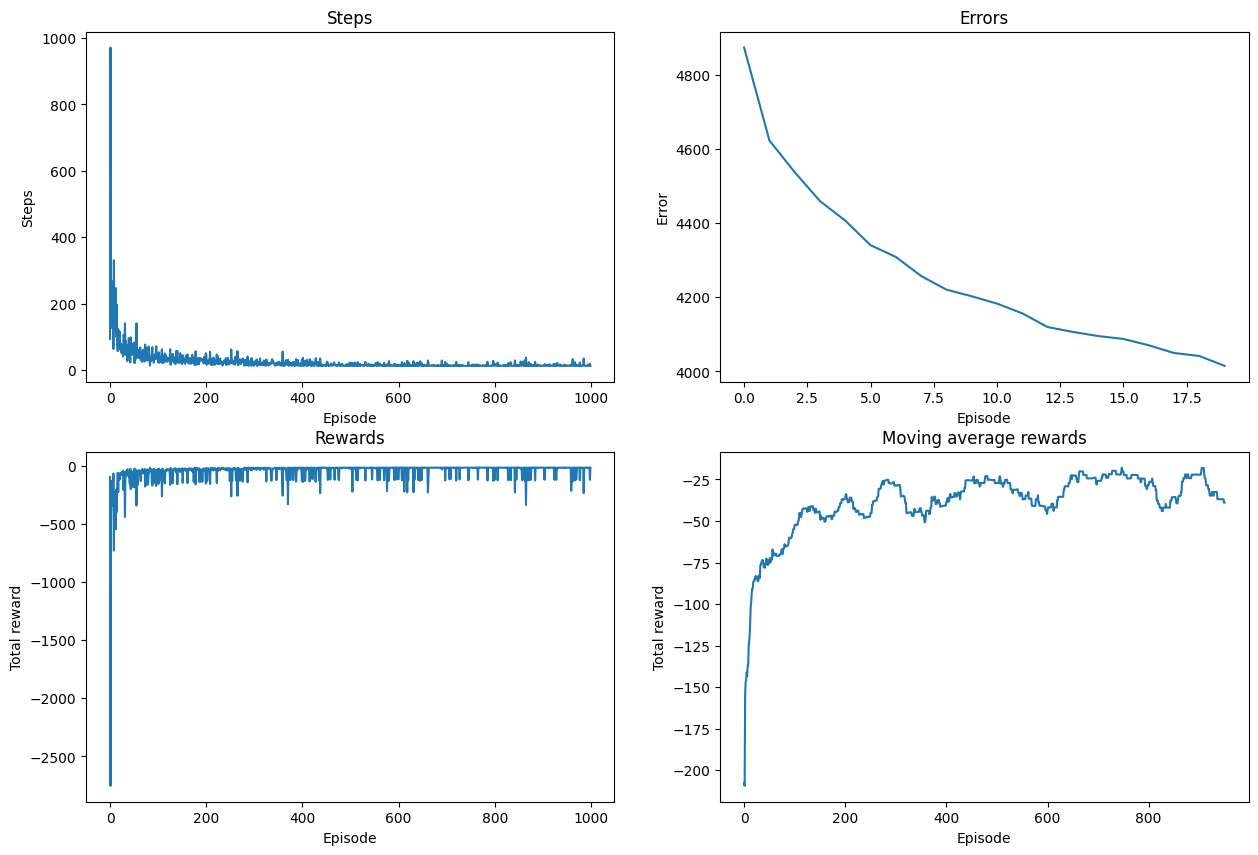

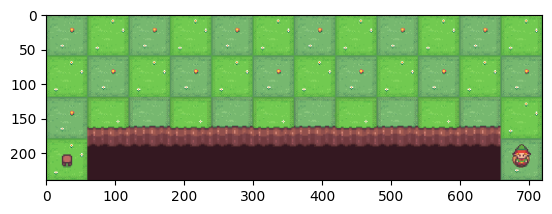

[CliffWalking-v0] DP: steps=13, reward=-13


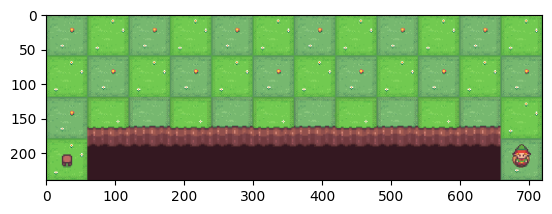

[CliffWalking-v0] Test: steps=13, reward=-13


In [51]:
WatkinsQAgent.run(
    gym.make('CliffWalking-v0'),
    n_episodes=1000,
    gamma=1,
    debug=True,
    seed=1,
    won=lambda _, reward: reward > -20,
    limit=50)

[FrozenLake-v1] DPQ converged in 178 iterations
[FrozenLake-v1] Episode 100: steps=53, reward=0.0, mean=0.20, error=36.36, mean Q=0.89, dev Q=0.10, max Q=0.99, min Q=0.65
[FrozenLake-v1] Episode 200: steps=8, reward=0.0, mean=0.31, error=32.79, mean Q=0.83, dev Q=0.14, max Q=0.99, min Q=0.51
[FrozenLake-v1] Episode 300: steps=26, reward=1.0, mean=0.29, error=29.68, mean Q=0.78, dev Q=0.17, max Q=0.99, min Q=0.41
[FrozenLake-v1] Episode 400: steps=16, reward=0.0, mean=0.42, error=27.53, mean Q=0.75, dev Q=0.19, max Q=0.99, min Q=0.39
[FrozenLake-v1] Episode 500: steps=12, reward=0.0, mean=0.45, error=25.98, mean Q=0.73, dev Q=0.21, max Q=0.99, min Q=0.37
[FrozenLake-v1] Episode 600: steps=56, reward=1.0, mean=0.53, error=25.02, mean Q=0.71, dev Q=0.21, max Q=0.99, min Q=0.35
[FrozenLake-v1] Episode 700: steps=89, reward=0.0, mean=0.51, error=24.22, mean Q=0.70, dev Q=0.22, max Q=0.99, min Q=0.35
[FrozenLake-v1] Episode 800: steps=6, reward=1.0, mean=0.48, error=23.44, mean Q=0.68, dev Q

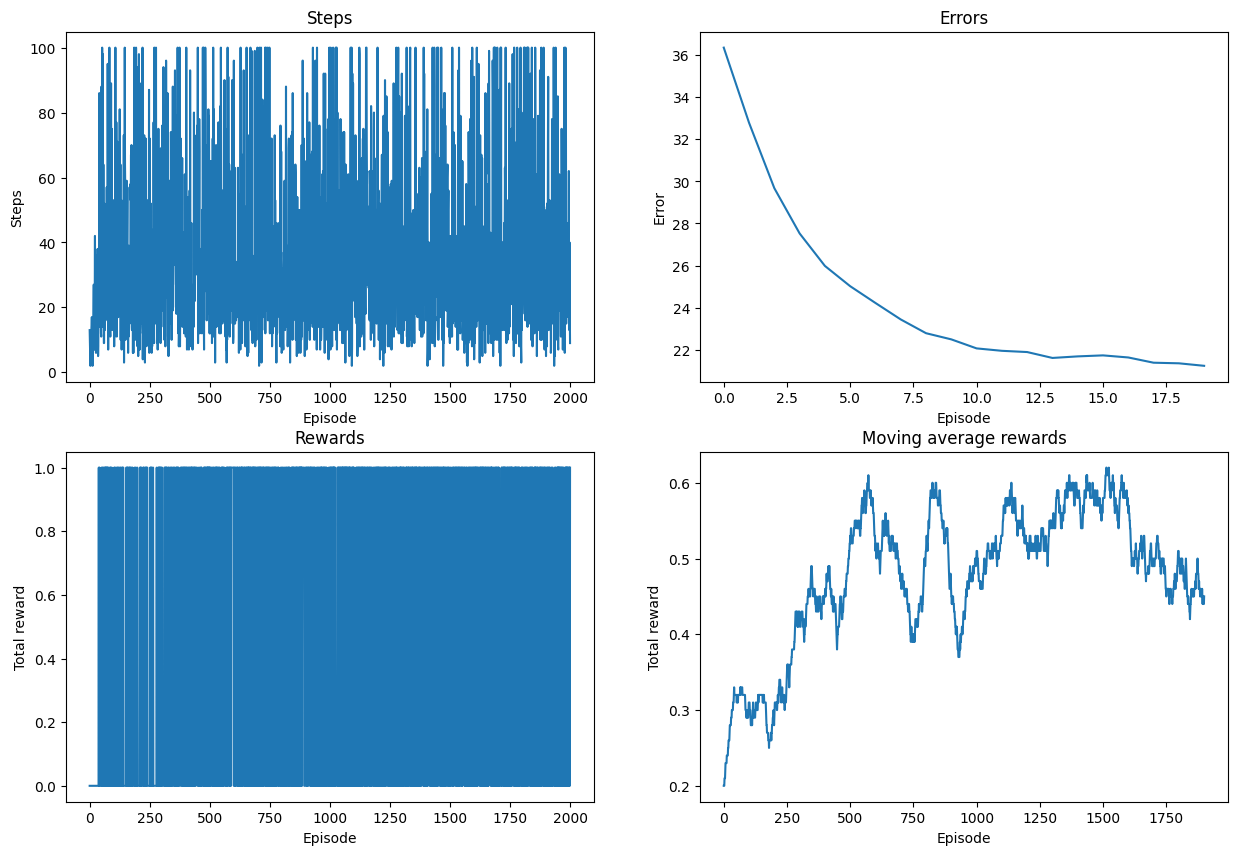

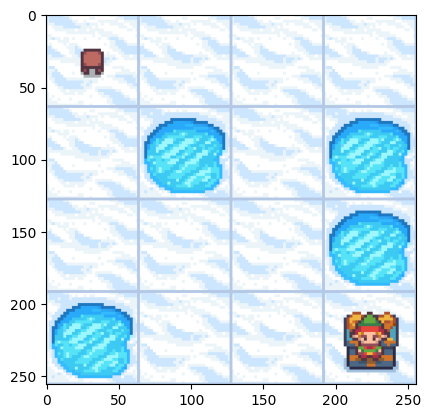

[FrozenLake-v1] DP: steps=41, reward=1.0


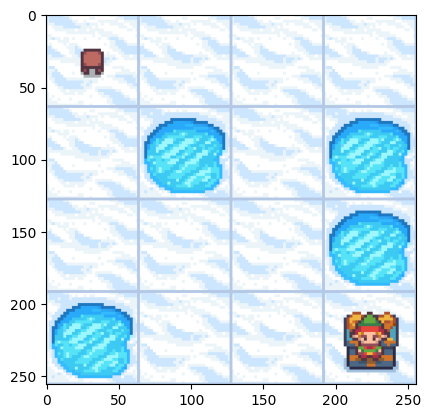

[FrozenLake-v1] Test: steps=41, reward=1.0


In [52]:
# Stochastic environment
def get_env(test=False):
    return gym.make('FrozenLake-v1', is_slippery=True, render_mode='rgb_array' if test else None)

WatkinsQAgent.run(
    env=get_env(),
    test_env=get_env(test=True),
    n_episodes=2000,
    gamma=0.99,
    initial_q_val=0.99,
    debug=True,
    seed=1,
    won=lambda _, reward: reward > 0)

# Alternatively:

# WatkinsQAgent.run(
#     env=get_env(),
#     test_env=get_env(test=True),
#     n_episodes=2000,
#     gamma=0.99,
#     greedy_with_noise=True,
#     debug=True,
#     seed=9,
#     won=lambda _, reward: reward > 0)

[FrozenLake-v1] DPQ converged in 8 iterations
[FrozenLake-v1] Episode 100: steps=7, reward=0.0, mean=0.01, error=33.65, mean Q=0.00, dev Q=0.01, max Q=0.10, min Q=0.00
[FrozenLake-v1] Episode 200: steps=12, reward=0.0, mean=0.11, error=33.10, mean Q=0.01, dev Q=0.06, max Q=0.49, min Q=0.00
[FrozenLake-v1] Episode 300: steps=6, reward=1.0, mean=0.41, error=31.04, mean Q=0.04, dev Q=0.16, max Q=0.94, min Q=0.00
[FrozenLake-v1] Episode 400: steps=6, reward=1.0, mean=1.00, error=28.17, mean Q=0.09, dev Q=0.27, max Q=1.00, min Q=0.00
[FrozenLake-v1] Episode 500: steps=6, reward=1.0, mean=1.00, error=27.80, mean Q=0.09, dev Q=0.28, max Q=1.00, min Q=0.00
[FrozenLake-v1] Episode 600: steps=6, reward=1.0, mean=1.00, error=27.79, mean Q=0.09, dev Q=0.28, max Q=1.00, min Q=0.00
[FrozenLake-v1] Episode 700: steps=6, reward=1.0, mean=1.00, error=27.79, mean Q=0.09, dev Q=0.28, max Q=1.00, min Q=0.00
[FrozenLake-v1] Episode 800: steps=6, reward=1.0, mean=1.00, error=27.79, mean Q=0.09, dev Q=0.28, 

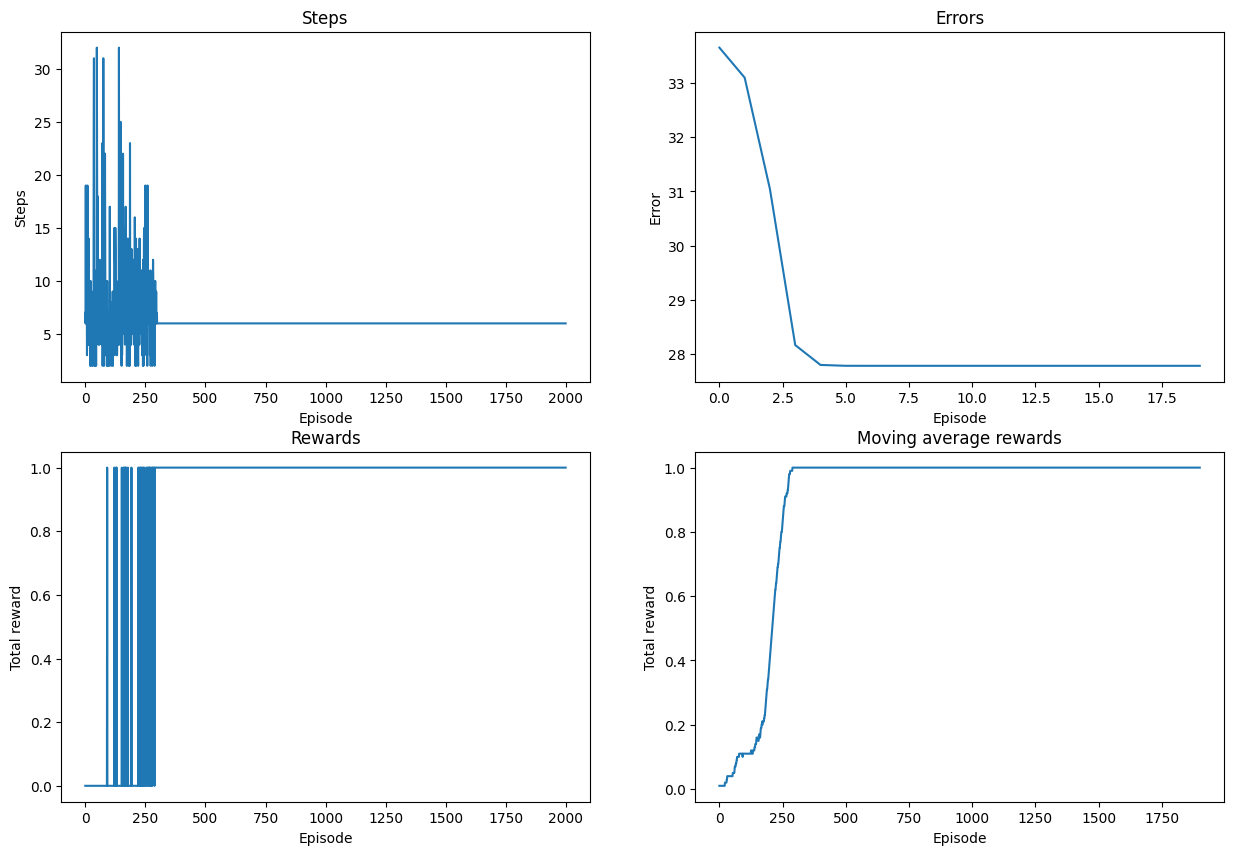

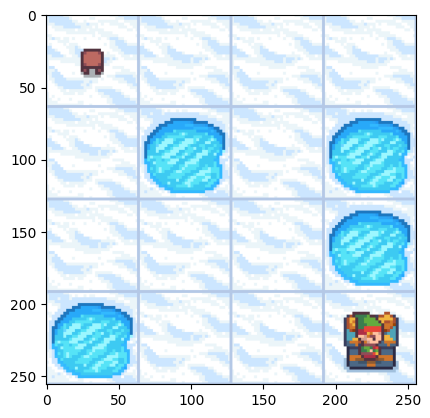

[FrozenLake-v1] DP: steps=6, reward=1.0


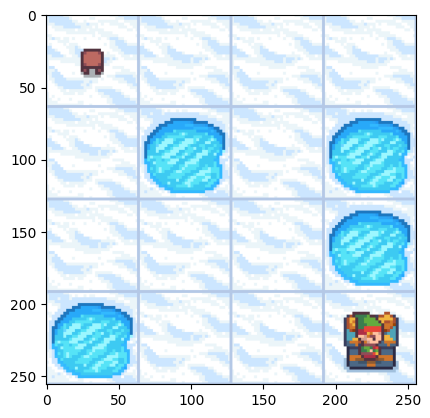

[FrozenLake-v1] Test: steps=6, reward=1.0


In [53]:
# Deterministic environment
def get_env(test=False):
    return gym.make('FrozenLake-v1', is_slippery=False, render_mode='rgb_array' if test else None)

WatkinsQAgent.run(
    env=get_env(),
    test_env=get_env(test=True),
    n_episodes=2000,
    gamma=0.99,
    greedy_with_noise=True,
    debug=True,
    seed=1,
    won=lambda _, reward: reward > 0)

# Alternatively:

# WatkinsQAgent.run(
#     env=get_env(),
#     test_env=get_env(test=True),
#     n_episodes=2000,
#     gamma=0.99,
#     initial_q_val=0.99,
#     debug=True,
#     seed=1,
#     won=lambda _, reward: reward > 0)

[Taxi-v3] DPQ converged in 13 iterations
[Taxi-v3] Episode 500: steps=93, reward=-117, mean=-194.80, error=13268.75, mean Q=-2.15, dev Q=1.87, max Q=19.90, min Q=-6.39
[Taxi-v3] Episode 1000: steps=76, reward=-91, mean=-78.94, error=12901.29, mean Q=-2.58, dev Q=2.45, max Q=20.00, min Q=-7.04
[Taxi-v3] Episode 1500: steps=13, reward=8, mean=-29.47, error=12742.23, mean Q=-2.72, dev Q=2.71, max Q=20.00, min Q=-8.00
[Taxi-v3] Episode 2000: steps=12, reward=9, mean=-6.49, error=12589.46, mean Q=-2.73, dev Q=2.85, max Q=20.00, min Q=-8.00
[Taxi-v3] Episode 2500: steps=8, reward=13, mean=-0.77, error=12436.80, mean Q=-2.72, dev Q=2.92, max Q=20.00, min Q=-8.00
[Taxi-v3] Episode 3000: steps=16, reward=5, mean=3.43, error=12303.12, mean Q=-2.70, dev Q=2.97, max Q=20.00, min Q=-8.00
[Taxi-v3] Episode 3500: steps=16, reward=5, mean=4.34, error=12177.08, mean Q=-2.67, dev Q=3.01, max Q=20.00, min Q=-8.21
[Taxi-v3] Episode 4000: steps=13, reward=8, mean=4.47, error=12057.95, mean Q=-2.64, dev Q=3

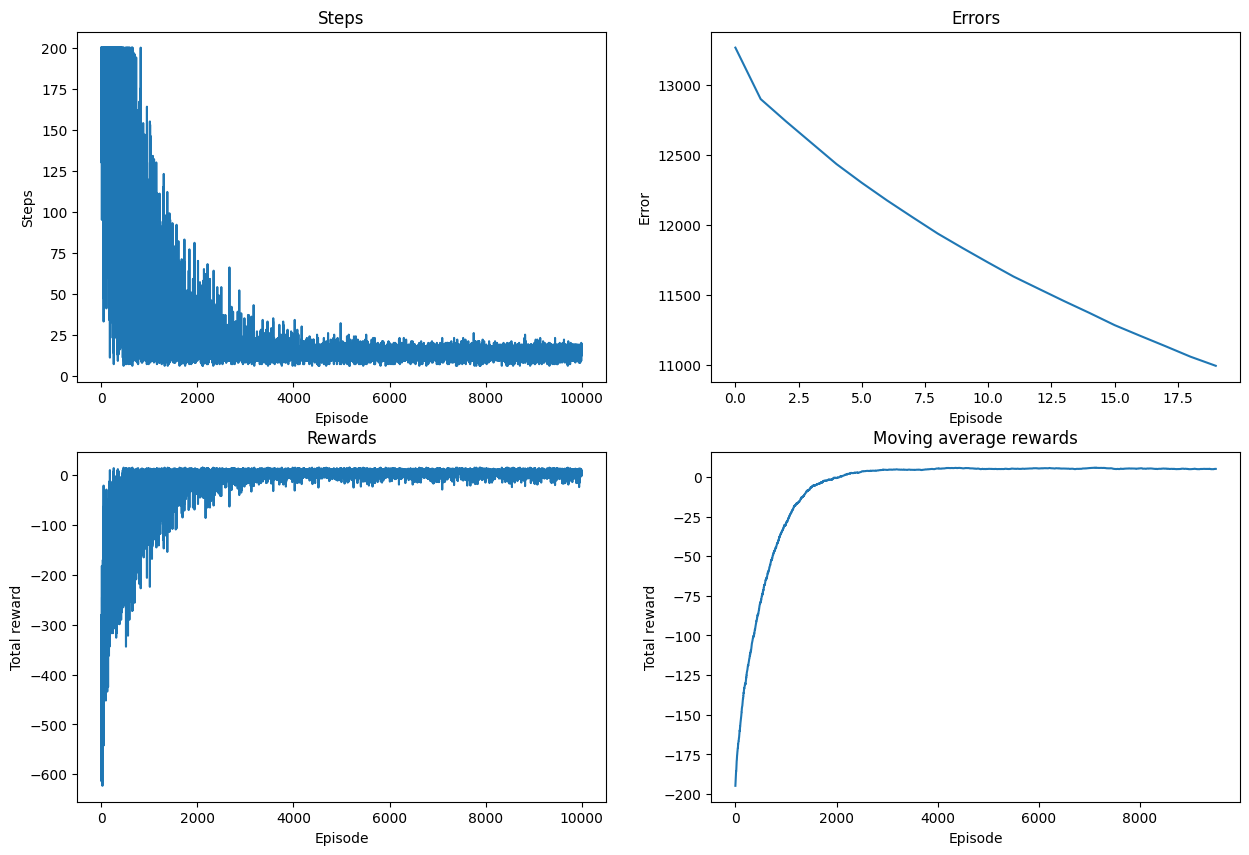

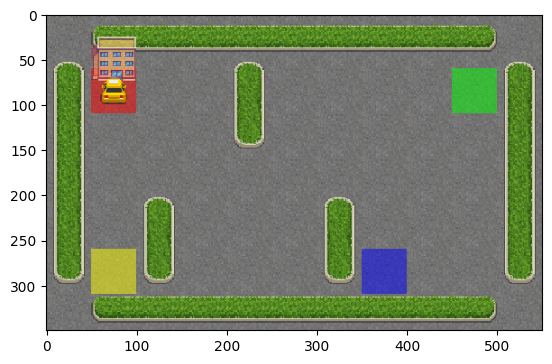

[Taxi-v3] DP: steps=12, reward=9


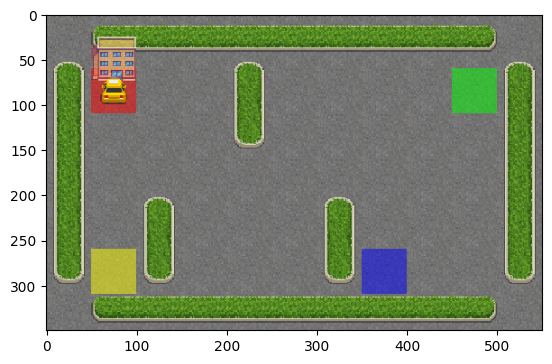

[Taxi-v3] Test: steps=14, reward=7


In [15]:
WatkinsQAgent.run(
    gym.make('Taxi-v3'),
    n_episodes=10000,
    debug=True,
    only_exploit=False,
    seed=1,
    won=lambda _, reward: reward > 0)

[Blackjack-v1] Episode 5000: steps=2, reward=1.0, mean=-0.14, mean Q=-0.02, dev Q=0.14, max Q=0.87, min Q=-0.71
[Blackjack-v1] Episode 10000: steps=1, reward=-1.0, mean=-0.05, mean Q=-0.02, dev Q=0.18, max Q=0.93, min Q=-0.78
[Blackjack-v1] Episode 15000: steps=4, reward=-1.0, mean=-0.09, mean Q=-0.02, dev Q=0.20, max Q=0.97, min Q=-0.81
[Blackjack-v1] Episode 20000: steps=1, reward=-1.0, mean=-0.08, mean Q=-0.03, dev Q=0.20, max Q=0.99, min Q=-0.82
[Blackjack-v1] Episode 25000: steps=1, reward=-1.0, mean=-0.09, mean Q=-0.03, dev Q=0.21, max Q=0.99, min Q=-0.84
[Blackjack-v1] Episode 30000: steps=2, reward=-1.0, mean=-0.09, mean Q=-0.04, dev Q=0.22, max Q=1.00, min Q=-0.82
[Blackjack-v1] Episode 35000: steps=2, reward=1.0, mean=-0.06, mean Q=-0.04, dev Q=0.22, max Q=1.00, min Q=-0.88
[Blackjack-v1] Episode 40000: steps=1, reward=0.0, mean=-0.07, mean Q=-0.04, dev Q=0.23, max Q=1.00, min Q=-0.87
[Blackjack-v1] Episode 45000: steps=2, reward=1.0, mean=-0.07, mean Q=-0.04, dev Q=0.23, max

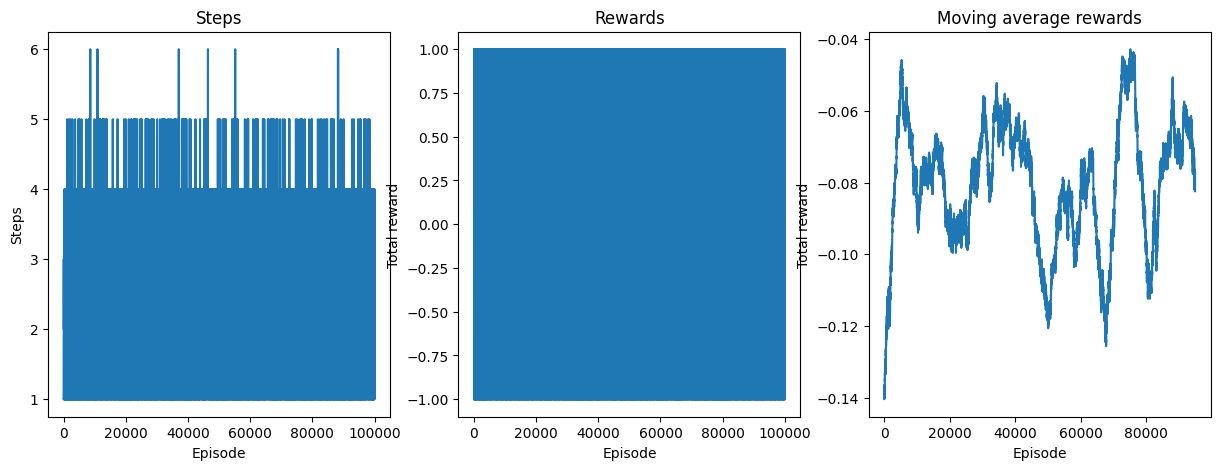

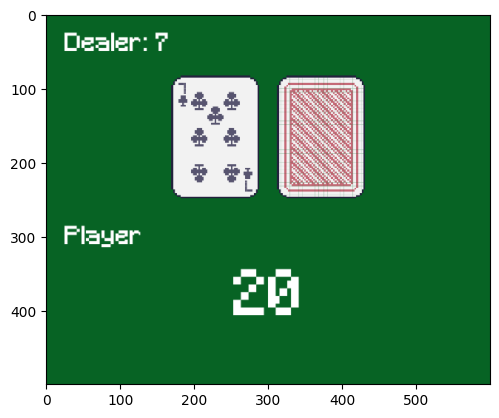

[Blackjack-v1] Test: steps=1, reward=1.0


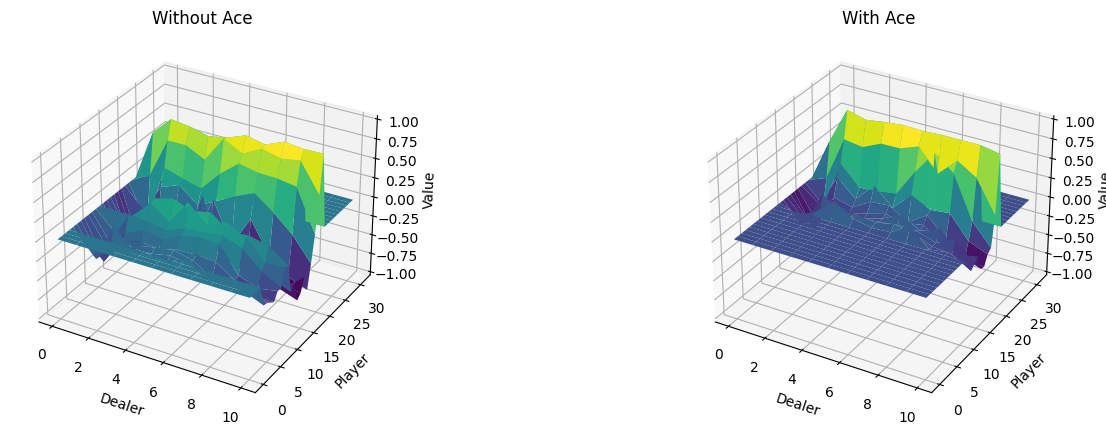

In [32]:
def plot(agent: WatkinsQAgent):
    # Plot 2 3D plots with and without Ace
    # x and y axis are the values of the player and the dealer
    # z axis is the value function (agent.q_table)
    fig = plt.figure(figsize=(16, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    def get_value(state_idx: int):
        action_idx = np.argmax(agent.q_table[state_idx])
        return agent.q_table[state_idx, action_idx]

    def plot_3d(ax, title, usable_ace):
        ax.set_title(title)
        ax.set_xlabel('Dealer')
        ax.set_ylabel('Player')
        ax.set_zlabel('Value')
        ax.set_zlim(-1, 1)

        y_max, x_max, _ = agent.observation_shape
        x = np.arange(x_max)
        y = np.arange(y_max)
        X, Y = np.meshgrid(x, y)
        Z = np.array([
            [
                get_value(agent.state_to_idx((player, dealer, 0+usable_ace)))
                for dealer in x
            ]
            for player in y])

        ax.plot_surface(X, Y, Z, cmap='viridis')

    plot_3d(ax1, 'Without Ace', usable_ace=False)
    plot_3d(ax2, 'With Ace', usable_ace=True)

WatkinsQAgent.run(
    env=gym.make('Blackjack-v1'),
    n_episodes=100000,
    debug=True,
    seed=1,
    won=lambda _, reward: reward > 0,
    observation_shape=(32, 11, 2),
    callback=plot)